# Notebook dedicated to solve and compute the cross-section of ES of solar Nu_e with electrons

The ideia is to compute the cross-section from the interaction solving the differential equation of dσ/dT, where T = E - m is the kinetic energy of the recoil electron electron in the ES interaction $\nu_e + e^- \rightarrow{} e^- + \nu_e$.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.ticker import AutoMinorLocator

from scipy.special import spence
import scipy.integrate as integrate

from cross_section import cross_sec_ES_nu_e, integrated_sigma

# Definitions

- Differential Cross Section:

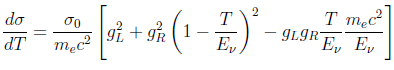

This cross-section can be computed analytically. 

- Differential Cross Section with radiative corrections (Only relevant for 8B and hep neutrinos!):

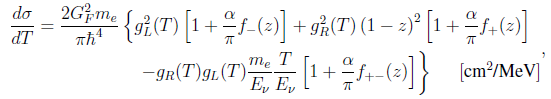

This cross section will need a numerical integration

## Electron Recoil Energy Formulas

Max Energy

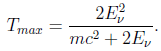

Min Energy (must be integrated over theta from 0 to 2pi

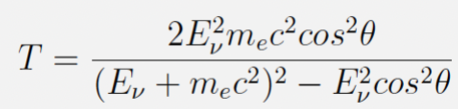

## Function for the minimun kinetic energy of the electron

In [30]:
def Tmin_func(theta, E_nu):
    
    '''
    Function to compute the minimum kinetic energy of the 
    recoil electron. This function mus be integrated with
    respect to theta in the interval [0, 2pi].
    
    Parameters:
    - theta: Angle of scattering
    - E_nu: energy of the incident neutrino in MeV
    
    return: Value of energy
    '''
    
    m_e = 0.5109989461 # Electron mass in MeV/c^2
    
    num = 2*(E_nu**2)*m_e*(np.cos(theta))**2
    den = (E_nu + m_e)**2 - (E_nu**2)*(np.cos(theta))**2
    
    T = (num/den) * (1 / (2*np.pi))
    
    return T

# Cross Section function (Analytical Solution)

In [15]:
def cross_sec_ES_nu_e(E_nu, flavor = 'nue'):
    
    """
    Compute the cross-section of neutrino-electron ES without radiative 
    corrections by analytically integrating dσ/dT between Tmin and Tmax(E).

    Parameters:
    -E_nu: scalar or array of neutrino energies (MeV)
    -flavor: neutrino flavor to compute the interactions cross-section.
                Default is electron neutrino flavor.

    returns: sigma(E) in same units as sigma0_over_me_c2 * MeV
    """

    E_nu = np.asarray(E_nu, dtype=float)

    # -------- constants --------

    pi = np.pi
    G_F = 1.16639 * 10 **(-11)               # Fermi Constant in MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    m_e = 0.5109989461                                          # electron mass energy in MeV/c^2 
    c = 3 * 10 ** (10)                                          # speed of light cm/s
    sigma_0 = (2 * (G_F **2) * (m_e**2)/pi) * (h_bar * c)**2    # cm^2
    g_R = 0.23116                                               # sin^2(Weinberg angle)
    
    if flavor == 'nue':
        g_L = g_R + 1/2
    
    elif flavor == 'numu' or nu_flavor == 'nutau':
        g_L = g_R - 1/2 
        
    else:
        print('Unknown neutrino flavor')
    
    
    # Recoil Electron Energy values:
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu) # Maximum Kinetic energy of recoil electron
    #Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0] # Minimum kinetic energy of recoil electron (Integration over theta)
    Tmin = 0
    # -------- Cross-section Computation --------

    # coefficients from algebra of the cross-section
    C0 = (g_L**2 + g_R**2)
    A1 = (-2.0 * g_R**2 / E_nu) - (g_L * g_R * m_e / (E_nu**2 + 1e-300))  # avoid div by 0
    A2 = g_R**2 / (E_nu**2 + 1e-300)

    # compute differences of integration
    dT = Tmax - Tmin
    dT2 = (Tmax**2 - Tmin**2)
    dT3 = (Tmax**3 - Tmin**3)

    integral = C0 * dT + 0.5 * A1 * dT2 + (1.0/3.0) * A2 * dT3
    
    # Final result
    sigma = (sigma_0 / m_e) * integral
    
    return sigma


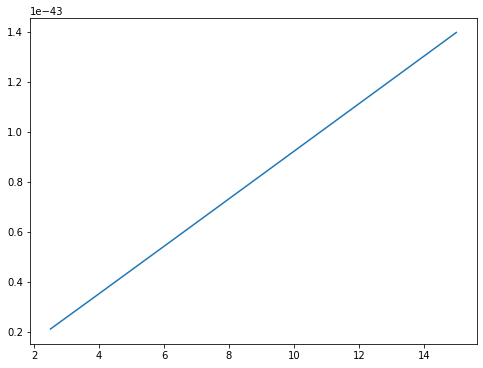

In [16]:
E_nu = np.linspace(2.5, 15, 200)
cross_sec = []

plt.figure(figsize = (8,6))
for E_nu_i in E_nu:
    cross_sec.append(cross_sec_ES_nu_e(E_nu_i))
    
plt.plot(E_nu, cross_sec)
plt.show()

# Cross Section Function with Radiative Corrections

We must write the differential cross section equation with radiative corrections and then solve it numerically

In [26]:
def dSigma_dT_corr(T, E_nu, flavor = 'nue'):
    
    '''
    Function that defines the differential cross section equation
    as a function of the recoil electron energy with QED radiative
    corrections.
    
    Parameters:
    -E_nu: scalar of neutrino energies (MeV)  
    -flavor: neutrino flavor to compute the interactions cross-section.
                Default is electron neutrino flavor.
    
    return: The value of the differential equation at each point
    
    NOTE: The Spence function function in scipy is different than 
          the convention in arXiv:astro-ph/9502003, so L(x) must be 
          written as L(1-x)
    '''
    
    E_nu = np.asarray(E_nu, dtype=float)
    
    # ---------- Constants ----------
    pi = np.pi
    G_F = 1.16639 * 10 **(-11)               # Fermi Constant in MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)    # Plank bar constant in MeV.s
    c = 3 * 10 ** (10)                       # speed of light cm/s
    m_e = 0.5109989461                       # electron mass energy in MeV/c^2 
    alpha = 1/137                            # Fine structure constant
    sin_theta_w_sqr = 0.23116                # sin^2(Weinberg angle)
    sigma_0 = (2 * (G_F **2) * (m_e**2)/pi) * (h_bar * c)**2
    
    # ---------- Recoil Electron Energy values ----------
    
    #Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)                    # Maximum Kinetic energy of recoil electron
    #Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0] # Minimum kinetic energy of recoil electron (Integration over theta)
    #T = np.linspace(Tmin, Tmax, 200)
    
    # -------- g_L(T) and g_R(T) functions for nu_e --------
    
    rho_NC = 1.0126
    x = np.sqrt(1 + 2*m_e/T)
    I = (1/6) * (1/3 + (3 - x**2) * (0.5 * x * np.log((x + 1)/(x - 1)) - 1))
    
    if flavor == 'nue':
        k = 0.9791 + 0.0097*I 
        g_L = rho_NC * (0.5 - k * sin_theta_w_sqr) - 1
        g_R = -rho_NC * k * sin_theta_w_sqr
    
    elif flavor == 'numu' or nu_flavor == 'nutau':
        k = 0.9970 - 0.00037*I 
        g_L = rho_NC * (0.5 - k * sin_theta_w_sqr)
        g_R = -rho_NC * k * sin_theta_w_sqr
        
    else:
        print('Unknown neutrino flavor')
    
    
    # -------- QED functions f+, f-, f+/- --------
    
    z = T / (E_nu + 1e-300)
    E_e = T + m_e                 #Electron energy = kinetic energy + rest mass energy
    p_e = np.sqrt(E_e**2 - m_e**2)  # Electron 3-momentum modulo
    beta = p_e / E_e
    
    epsilon = 1e-100  #Logaritmic regularizer
    
    # f-
    term1_minus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - (5/12))
    term2_minus = 0.5*(spence(1 - z) - spence(1 - beta)) - 0.5 * (np.log(np.maximum(1 - z, epsilon)))**(2) - (11/12 + z/2) * np.log(np.maximum(1 - z, epsilon))
    term3_minus = z * (np.log(np.maximum(z, epsilon)) + 0.5*np.log(2*E_nu/m_e)) - (31/18 + (1/12)*np.log(np.maximum(z, epsilon)))*beta - (11/12)*z + (z**2)/24
    
    f_minus = term1_minus + term2_minus + term3_minus
    
    # (1-z)^2 * f+
    term1_plus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(((1 - z)**2) * (2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - 2/3) - 0.5*((z**2)*np.log(np.maximum(z, epsilon)) + 1 - z))
    term2_plus = -(0.5*(1 - z)**2)*((np.log(np.maximum(1 - z, epsilon)))**2 + beta * (spence(z) - np.log(np.maximum(z, epsilon))*np.log(np.maximum(1 - z, epsilon))))
    term3_plus = np.log(np.maximum(1 - z, epsilon))*(0.5*(z**2) * np.log(np.maximum(z, epsilon)) + ((1 - z)/3) * (2*z - 0.5))
    term4_plus = -0.5*(z**2)*spence(z) - (z*(1 - 2*z)/3) * np.log(np.maximum(z, epsilon)) - z*(1-z)/6
    term5_plus = -(beta/12) * (np.log(np.maximum(z, epsilon)) + (1 - z)*((115 - 109*z)/6))
    
    f_plus_prod = term1_plus + term2_plus + term3_plus + term4_plus + term5_plus
    f_plus = f_plus_prod / ((1-z)**2)
    
    # f+/-
    f_pm = ((E_e/p_e)*np.log((E_e + p_e) / m_e) - 1) * 2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon))
    
    # ------ Differential Cross Section Calculation in cm^2 / MeV ------

    term1 = (g_L**2) * (1 + (alpha/pi) * f_minus)
    term2 = ((g_R * (1 - z))**2) * (1 + (alpha/pi) * (f_plus))
    term3 = -g_R * g_L * ((m_e * T)/(E_nu**2)) * (1 + (alpha/pi) * (f_pm))
    
    result = (sigma_0 / m_e) * (term1 + term2 + term3)  
    
    return result

## Numerically Integrate dSigma_dT_corr Function

1) Propose a range of E_nu;
2) Integrate the function with respect to electron kinetic energy for all E_nu values;
3) Save the Value of the integration as the cross section with the radiative corrections;


In [27]:
def integrated_sigma(E_nu, flavor = 'nue'):

    '''
    Function that takes the dSigma_dT_corr function and integrate with respect to the
    electron kinetic energy. The integration is done numerically with the quad method 
    of scipy. The function computes the Tmax and Tmin of the recoil electron and takes
    the values as the integral limits.

    Parameters:
    - E_nu: Energy of the incident neutrino
    - flavor: neutrino flavor to compute the interactions cross-section.
                Default is electron neutrino flavor.

    return: Values of the cross-section for a neutrino energy
    
    '''

    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    pi = np.pi
    
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)
    Tmin = 0
    #Tmin, _ = integrate.quad(Tmin_func, 0, 2*pi, args=(E_nu))
    
    #print(f"--- Integrating for E_nu = {E_nu:.2f} MeV ---")
    #print(f"Limits of T_e: [{Tmin:.4f}, {Tmax:.4f}] MeV")
    
    sigma, abs_error = integrate.quad(
        dSigma_dT_corr, 
        Tmin, 
        Tmax, 
        args=(E_nu, flavor)
    )
    
    #print(f"result of integration: {sigma:.6e} cm^2")
    
    return sigma

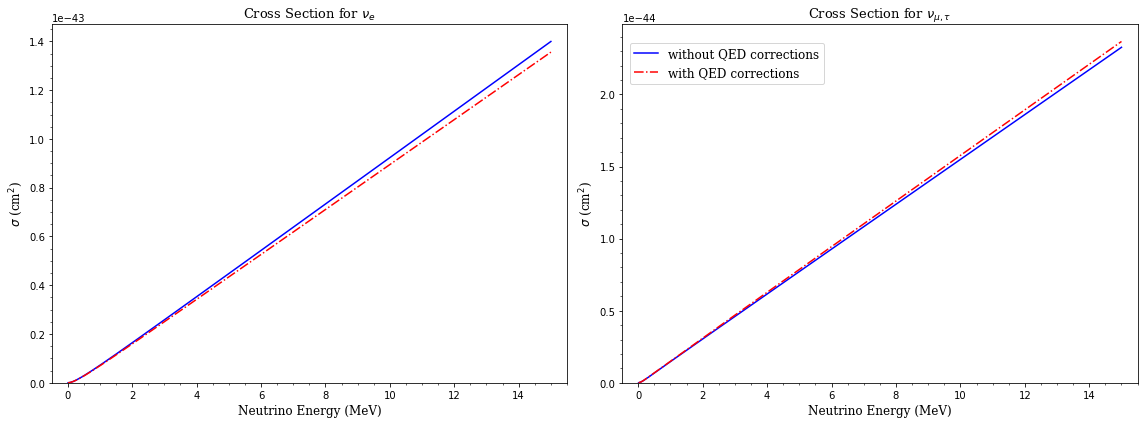

In [59]:
E_nu_min = 0.01
E_nu_max = 15
flavor = 'numu'

E_nu = np.linspace(E_nu_min, E_nu_max, 200)

cross_sec_nue = []
cross_sec_corr_nue = []

cross_sec_numu = []
cross_sec_corr_numu = []


for E_nu_i in E_nu:
    cross_sec_nue.append(cross_sec_ES_nu_e(E_nu_i, flavor = 'nue'))
    cross_sec_corr_nue.append(integrated_sigma(E_nu_i, flavor = 'nue'))
    
    cross_sec_numu.append(cross_sec_ES_nu_e(E_nu_i, flavor = 'numu'))
    cross_sec_corr_numu.append(integrated_sigma(E_nu_i, flavor = 'numu'))
    
# =========== Plots ===========

font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':13}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':12}
font_prop = font_manager.FontProperties(family=font_style_axis['family'], weight=font_style_axis['weight'], size=font_style_axis['size'])
fig, axes = plt.subplots(1, 2,  figsize=(16, 6))

# ------------- Right Plot -------------

axes[0].plot(E_nu, cross_sec_nue, color = 'b', label = 'without QED corrections')
axes[0].plot(E_nu, cross_sec_corr_nue, color = 'r', linestyle = '-.', label = 'with QED corrections')

axes[0].set_xlabel('Neutrino Energy (MeV)', fontdict = font_style_axis)
axes[0].set_ylabel(r'$\sigma$ (cm$^2$)', fontdict = font_style_axis)

axes[0].set_title(r'Cross Section for $\nu_e$', fontdict = font_style_title)

# ------------- Left Plot -------------

axes[1].plot(E_nu, cross_sec_numu, color = 'b')
axes[1].plot(E_nu, cross_sec_corr_numu, color = 'r', linestyle = '-.')

axes[1].set_xlabel('Neutrino Energy (MeV)', fontdict = font_style_axis)
axes[1].set_ylabel(r'$\sigma$ (cm$^2$)', fontdict = font_style_axis)

axes[1].set_title(r'Cross Section for $\nu_{{\mu, \tau}}$', fontdict = font_style_title)

# ---- Axis limits per subplot ----
for ax in axes:
    ax.set_xlim(E_nu_min - 0.5, E_nu_max + 0.5)
    ax.set_ylim(0, None)

    # Minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    # Optional: nicer grid
    #ax.grid(which='both', alpha=0.25)

# Global legend
fig.legend(loc= (0.55,0.8), ncol=1, prop = font_prop, labelcolor = font_style_axis['color'])

plt.tight_layout()
plt.show()

## QED Functions Check
Use this functions with only one value for neutrino energy!

In [88]:
def f_minus(E_nu):
    
    pi = np.pi
    G_F = 1.16639 * 10 **(-11)               # Fermi Constant MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    m_e = 0.5109989461                      # electron mass energy in MeV
    alpha = 1/137                           # Fine structure constant
    sin_theta_w = 0.23116                   # sin^2(Weinberg angle)
    
    E_nu = np.asarray(E_nu, dtype=float)     # Neutrino Energy
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu) #Electron max. kinetic energy
    Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0] #Electron min. kinetic energy
    T = np.linspace(Tmin, Tmax, 200)
    
    E_e = T + m_e                             # Total electron energy
    z = T / (E_nu + 1e-300)
    p_e = np.sqrt(E_e**2 - m_e**2)            # electron 3-momentum modulo
    beta = p_e / (E_e)
    
    # f-
    epsilon = 1e-100  #Logaritmic regularizer
    
    term1_minus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - (5/12))
    term2_minus = 0.5*(spence(1 - z) - spence(1 - beta)) - 0.5 * (np.log(np.maximum(1 - z, epsilon)))**(2) - (11/12 + z/2) * np.log(np.maximum(1 - z, epsilon))
    term3_minus = z * (np.log(np.maximum(z, epsilon)) + 0.5*np.log(2*E_nu/m_e)) - (31/18 + (1/12)*np.log(np.maximum(z, epsilon)))*beta - (11/12)*z + (z**2)/24
    
    f_minus = term1_minus + term2_minus + term3_minus
    
    return {'T': T, 'z': z, 'f_minus': f_minus}
    
    
def f_plus(E_nu):
    
    pi = np.pi
    G_F = 1.16639 * 10 **(-11)               # Fermi Constant MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    alpha = 1/137                           # Fine structure constant
    sin_theta_w = 0.23116                   # sin^2(Weinberg angle)
    
    E_nu = np.asarray(E_nu, dtype=float)
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)
    Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0]
    T = np.linspace(Tmin, Tmax, 200)
    
    E_e = T + m_e 
    z = T / (E_nu + 1e-300)
    p_e = np.sqrt(E_e**2 - m_e**2)
    beta = p_e / (E_e)

    # (1-z)^2 * f+
    epsilon = 1e-100  #Logaritmic regularizer
    term1_plus = ((E_e/p_e)*np.log((E_e + p_e)/m_e) - 1)*(((1 - z)**2) * (2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon)) - np.log(np.maximum(1 - z, epsilon)) - 0.5*np.log(np.maximum(z, epsilon)) - 2/3) - 0.5*((z**2)*np.log(np.maximum(z, epsilon)) + 1 - z))
    term2_plus = -(0.5*(1 - z)**2)*((np.log(np.maximum(1 - z, epsilon)))**2 + beta * (spence(z) - np.log(np.maximum(z, epsilon))*np.log(np.maximum(1 - z, epsilon))))
    term3_plus = np.log(np.maximum(1 - z, epsilon))*(0.5*(z**2) * np.log(np.maximum(z, epsilon)) + ((1 - z)/3) * (2*z - 0.5))
    term4_plus = -0.5*(z**2)*spence(z) - (z*(1 - 2*z)/3) * np.log(np.maximum(z, epsilon)) - z*(1-z)/6
    term5_plus = -(beta/12) * (np.log(np.maximum(z, epsilon)) + (1 - z)*((115 - 109*z)/6))
    
    f_plus_prod = term1_plus + term2_plus + term3_plus + term4_plus + term5_plus
    f_plus = f_plus_prod / ((1-z)**2)
    
    return {'z': z, 'f_plus': f_plus}
    

def f_pm(E_nu):
    
    pi = np.pi
    G_F = 1.16639 * 10 **(-11)               # Fermi Constant MeV^(-2)
    h_bar = (4.135668 * 10**(-21))/(2*pi)   # Plank bar constant in MeV.s
    m_e = 0.5109989461                      # electron mass energy in MeV/c^2 
    alpha = 1/137                           # Fine structure constant
    sin_theta_w = 0.23116                   # sin^2(Weinberg angle)
    
    E_nu = np.asarray(E_nu, dtype=float)
    Tmax = 2.0 * E_nu**2 / (m_e + 2.0 * E_nu)
    Tmin = integrate.quad(Tmin_func, 0, 2*np.pi, args=(E_nu))[0]
    T = np.linspace(Tmin, Tmax, 200)
    
    E_e = T + m_e 
    z = T / (E_nu + 1e-300)
    p_e = np.sqrt(E_e**2 - m_e**2)
    beta = p_e / (E_e)
    
    epsilon = 1e-100  #Logaritmic regularizer
    f_pm = ((E_e/p_e)*np.log((E_e + p_e) / m_e) - 1) * 2*np.log(np.maximum(1 - z - m_e/(E_e + p_e), epsilon))
    return {'z': z, 'f_pm': f_pm}

In [89]:
E_nu = 10

z_minus_val = f_minus(E_nu)['z']
f_minus_val = f_minus(E_nu)['f_minus']
T_minus_val = f_minus(E_nu)['T']

z_plus_val = f_plus(E_nu)['z']
f_plus_val = f_plus(E_nu)['f_plus']

z_pm_val = f_pm(E_nu)['z']
f_pm_val = f_pm(E_nu)['f_pm']

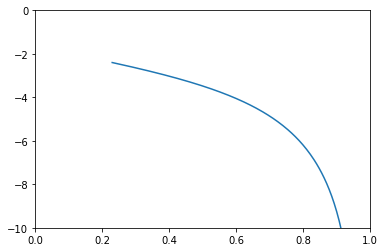

In [90]:
plt.plot(z_minus_val, f_minus_val)
plt.xlim(0, 1)
plt.ylim(-10, 0)
plt.show()

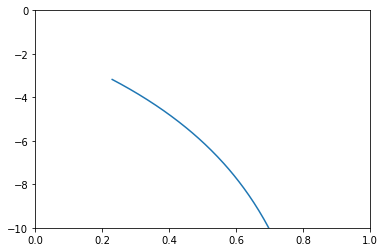

In [91]:
plt.plot(z_plus_val, f_plus_val)
plt.xlim(0, 1)
plt.ylim(-10, 0)
plt.show()

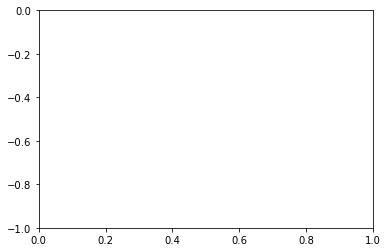

In [92]:
plt.plot(z_pm_val, f_pm_val)
plt.xlim(0, 1)
plt.ylim(-1, 0)
plt.show()

# Cross Section Cross Check with RATDB 

In [34]:
energy_nue = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.10, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.20, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.30, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.40, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.50, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.60, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.70, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.80, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.90, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.00, 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.10, 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.20, 2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.30, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.40, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.50, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.60, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.70, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.80, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.90, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.00, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.10, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.20, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.30, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.40, 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.50, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.60, 3.61, 3.62, 3.63, 3.64, 3.65, 3.66, 3.67, 3.68, 3.69, 3.70, 3.71, 3.72, 3.73, 3.74, 3.75, 3.76, 3.77, 3.78, 3.79, 3.80, 3.81, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.89, 3.90, 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.00, 4.01, 4.02, 4.03, 4.04, 4.05, 4.06, 4.07, 4.08, 4.09, 4.10, 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.20, 4.21, 4.22, 4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30, 4.31, 4.32, 4.33, 4.34, 4.35, 4.36, 4.37, 4.38, 4.39, 4.40, 4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.50, 4.51, 4.52, 4.53, 4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.60, 4.61, 4.62, 4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.70, 4.71, 4.72, 4.73, 4.74, 4.75, 4.76, 4.77, 4.78, 4.79, 4.80, 4.81, 4.82, 4.83, 4.84, 4.85, 4.86, 4.87, 4.88, 4.89, 4.90, 4.91, 4.92, 4.93, 4.94, 4.95, 4.96, 4.97, 4.98, 4.99, 5.00, 5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.08, 5.09, 5.10, 5.11, 5.12, 5.13, 5.14, 5.15, 5.16, 5.17, 5.18, 5.19, 5.20, 5.21, 5.22, 5.23, 5.24, 5.25, 5.26, 5.27, 5.28, 5.29, 5.30, 5.31, 5.32, 5.33, 5.34, 5.35, 5.36, 5.37, 5.38, 5.39, 5.40, 5.41, 5.42, 5.43, 5.44, 5.45, 5.46, 5.47, 5.48, 5.49, 5.50, 5.51, 5.52, 5.53, 5.54, 5.55, 5.56, 5.57, 5.58, 5.59, 5.60, 5.61, 5.62, 5.63, 5.64, 5.65, 5.66, 5.67, 5.68, 5.69, 5.70, 5.71, 5.72, 5.73, 5.74, 5.75, 5.76, 5.77, 5.78, 5.79, 5.80, 5.81, 5.82, 5.83, 5.84, 5.85, 5.86, 5.87, 5.88, 5.89, 5.90, 5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 6.00, 6.01, 6.02, 6.03, 6.04, 6.05, 6.06, 6.07, 6.08, 6.09, 6.10, 6.11, 6.12, 6.13, 6.14, 6.15, 6.16, 6.17, 6.18, 6.19, 6.20, 6.21, 6.22, 6.23, 6.24, 6.25, 6.26, 6.27, 6.28, 6.29, 6.30, 6.31, 6.32, 6.33, 6.34, 6.35, 6.36, 6.37, 6.38, 6.39, 6.40, 6.41, 6.42, 6.43, 6.44, 6.45, 6.46, 6.47, 6.48, 6.49, 6.50, 6.51, 6.52, 6.53, 6.54, 6.55, 6.56, 6.57, 6.58, 6.59, 6.60, 6.61, 6.62, 6.63, 6.64, 6.65, 6.66, 6.67, 6.68, 6.69, 6.70, 6.71, 6.72, 6.73, 6.74, 6.75, 6.76, 6.77, 6.78, 6.79, 6.80, 6.81, 6.82, 6.83, 6.84, 6.85, 6.86, 6.87, 6.88, 6.89, 6.90, 6.91, 6.92, 6.93, 6.94, 6.95, 6.96, 6.97, 6.98, 6.99, 7.00, 7.01, 7.02, 7.03, 7.04, 7.05, 7.06, 7.07, 7.08, 7.09, 7.10, 7.11, 7.12, 7.13, 7.14, 7.15, 7.16, 7.17, 7.18, 7.19, 7.20, 7.21, 7.22, 7.23, 7.24, 7.25, 7.26, 7.27, 7.28, 7.29, 7.30, 7.31, 7.32, 7.33, 7.34, 7.35, 7.36, 7.37, 7.38, 7.39, 7.40, 7.41, 7.42, 7.43, 7.44, 7.45, 7.46, 7.47, 7.48, 7.49, 7.50, 7.51, 7.52, 7.53, 7.54, 7.55, 7.56, 7.57, 7.58, 7.59, 7.60, 7.61, 7.62, 7.63, 7.64, 7.65, 7.66, 7.67, 7.68, 7.69, 7.70, 7.71, 7.72, 7.73, 7.74, 7.75, 7.76, 7.77, 7.78, 7.79, 7.80, 7.81, 7.82, 7.83, 7.84, 7.85, 7.86, 7.87, 7.88, 7.89, 7.90, 7.91, 7.92, 7.93, 7.94, 7.95, 7.96, 7.97, 7.98, 7.99, 8.00, 8.01, 8.02, 8.03, 8.04, 8.05, 8.06, 8.07, 8.08, 8.09, 8.10, 8.11, 8.12, 8.13, 8.14, 8.15, 8.16, 8.17, 8.18, 8.19, 8.20, 8.21, 8.22, 8.23, 8.24, 8.25, 8.26, 8.27, 8.28, 8.29, 8.30, 8.31, 8.32, 8.33, 8.34, 8.35, 8.36, 8.37, 8.38, 8.39, 8.40, 8.41, 8.42, 8.43, 8.44, 8.45, 8.46, 8.47, 8.48, 8.49, 8.50, 8.51, 8.52, 8.53, 8.54, 8.55, 8.56, 8.57, 8.58, 8.59, 8.60, 8.61, 8.62, 8.63, 8.64, 8.65, 8.66, 8.67, 8.68, 8.69, 8.70, 8.71, 8.72, 8.73, 8.74, 8.75, 8.76, 8.77, 8.78, 8.79, 8.80, 8.81, 8.82, 8.83, 8.84, 8.85, 8.86, 8.87, 8.88, 8.89, 8.90, 8.91, 8.92, 8.93, 8.94, 8.95, 8.96, 8.97, 8.98, 8.99, 9.00, 9.01, 9.02, 9.03, 9.04, 9.05, 9.06, 9.07, 9.08, 9.09, 9.10, 9.11, 9.12, 9.13, 9.14, 9.15, 9.16, 9.17, 9.18, 9.19, 9.20, 9.21, 9.22, 9.23, 9.24, 9.25, 9.26, 9.27, 9.28, 9.29, 9.30, 9.31, 9.32, 9.33, 9.34, 9.35, 9.36, 9.37, 9.38, 9.39, 9.40, 9.41, 9.42, 9.43, 9.44, 9.45, 9.46, 9.47, 9.48, 9.49, 9.50, 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57, 9.58, 9.59, 9.60, 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68, 9.69, 9.70, 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79, 9.80, 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.90, 9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10.00, 10.01, 10.02, 10.03, 10.04, 10.05, 10.06, 10.07, 10.08, 10.09, 10.10, 10.11, 10.12, 10.13, 10.14, 10.15, 10.16, 10.17, 10.18, 10.19, 10.20, 10.21, 10.22, 10.23, 10.24, 10.25, 10.26, 10.27, 10.28, 10.29, 10.30, 10.31, 10.32, 10.33, 10.34, 10.35, 10.36, 10.37, 10.38, 10.39, 10.40, 10.41, 10.42, 10.43, 10.44, 10.45, 10.46, 10.47, 10.48, 10.49, 10.50, 10.51, 10.52, 10.53, 10.54, 10.55, 10.56, 10.57, 10.58, 10.59, 10.60, 10.61, 10.62, 10.63, 10.64, 10.65, 10.66, 10.67, 10.68, 10.69, 10.70, 10.71, 10.72, 10.73, 10.74, 10.75, 10.76, 10.77, 10.78, 10.79, 10.80, 10.81, 10.82, 10.83, 10.84, 10.85, 10.86, 10.87, 10.88, 10.89, 10.90, 10.91, 10.92, 10.93, 10.94, 10.95, 10.96, 10.97, 10.98, 10.99, 11.00, 11.01, 11.02, 11.03, 11.04, 11.05, 11.06, 11.07, 11.08, 11.09, 11.10, 11.11, 11.12, 11.13, 11.14, 11.15, 11.16, 11.17, 11.18, 11.19, 11.20, 11.21, 11.22, 11.23, 11.24, 11.25, 11.26, 11.27, 11.28, 11.29, 11.30, 11.31, 11.32, 11.33, 11.34, 11.35, 11.36, 11.37, 11.38, 11.39, 11.40, 11.41, 11.42, 11.43, 11.44, 11.45, 11.46, 11.47, 11.48, 11.49, 11.50, 11.51, 11.52, 11.53, 11.54, 11.55, 11.56, 11.57, 11.58, 11.59, 11.60, 11.61, 11.62, 11.63, 11.64, 11.65, 11.66, 11.67, 11.68, 11.69, 11.70, 11.71, 11.72, 11.73, 11.74, 11.75, 11.76, 11.77, 11.78, 11.79, 11.80, 11.81, 11.82, 11.83, 11.84, 11.85, 11.86, 11.87, 11.88, 11.89, 11.90, 11.91, 11.92, 11.93, 11.94, 11.95, 11.96, 11.97, 11.98, 11.99, 12.00, 12.01, 12.02, 12.03, 12.04, 12.05, 12.06, 12.07, 12.08, 12.09, 12.10, 12.11, 12.12, 12.13, 12.14, 12.15, 12.16, 12.17, 12.18, 12.19, 12.20, 12.21, 12.22, 12.23, 12.24, 12.25, 12.26, 12.27, 12.28, 12.29, 12.30, 12.31, 12.32, 12.33, 12.34, 12.35, 12.36, 12.37, 12.38, 12.39, 12.40, 12.41, 12.42, 12.43, 12.44, 12.45, 12.46, 12.47, 12.48, 12.49, 12.50, 12.51, 12.52, 12.53, 12.54, 12.55, 12.56, 12.57, 12.58, 12.59, 12.60, 12.61, 12.62, 12.63, 12.64, 12.65, 12.66, 12.67, 12.68, 12.69, 12.70, 12.71, 12.72, 12.73, 12.74, 12.75, 12.76, 12.77, 12.78, 12.79, 12.80, 12.81, 12.82, 12.83, 12.84, 12.85, 12.86, 12.87, 12.88, 12.89, 12.90, 12.91, 12.92, 12.93, 12.94, 12.95, 12.96, 12.97, 12.98, 12.99, 13.00, 13.01, 13.02, 13.03, 13.04, 13.05, 13.06, 13.07, 13.08, 13.09, 13.10, 13.11, 13.12, 13.13, 13.14, 13.15, 13.16, 13.17, 13.18, 13.19, 13.20, 13.21, 13.22, 13.23, 13.24, 13.25, 13.26, 13.27, 13.28, 13.29, 13.30, 13.31, 13.32, 13.33, 13.34, 13.35, 13.36, 13.37, 13.38, 13.39, 13.40, 13.41, 13.42, 13.43, 13.44, 13.45, 13.46, 13.47, 13.48, 13.49, 13.50, 13.51, 13.52, 13.53, 13.54, 13.55, 13.56, 13.57, 13.58, 13.59, 13.60, 13.61, 13.62, 13.63, 13.64, 13.65, 13.66, 13.67, 13.68, 13.69, 13.70, 13.71, 13.72, 13.73, 13.74, 13.75, 13.76, 13.77, 13.78, 13.79, 13.80, 13.81, 13.82, 13.83, 13.84, 13.85, 13.86, 13.87, 13.88, 13.89, 13.90, 13.91, 13.92, 13.93, 13.94, 13.95, 13.96, 13.97, 13.98, 13.99, 14.00, 14.01, 14.02, 14.03, 14.04, 14.05, 14.06, 14.07, 14.08, 14.09, 14.10, 14.11, 14.12, 14.13, 14.14, 14.15, 14.16, 14.17, 14.18, 14.19, 14.20, 14.21, 14.22, 14.23, 14.24, 14.25, 14.26, 14.27, 14.28, 14.29, 14.30, 14.31, 14.32, 14.33, 14.34, 14.35, 14.36, 14.37, 14.38, 14.39, 14.40, 14.41, 14.42, 14.43, 14.44, 14.45, 14.46, 14.47, 14.48, 14.49, 14.50, 14.51, 14.52, 14.53, 14.54, 14.55, 14.56, 14.57, 14.58, 14.59, 14.60, 14.61, 14.62, 14.63, 14.64, 14.65, 14.66, 14.67, 14.68, 14.69, 14.70, 14.71, 14.72, 14.73, 14.74, 14.75, 14.76, 14.77, 14.78, 14.79, 14.80, 14.81, 14.82, 14.83, 14.84, 14.85, 14.86, 14.87, 14.88, 14.89, 14.90, 14.91, 14.92, 14.93, 14.94, 14.95, 14.96, 14.97, 14.98, 14.99, 15.00, 15.01, 15.02, 15.03, 15.04, 15.05, 15.06, 15.07, 15.08, 15.09, 15.10, 15.11, 15.12, 15.13, 15.14, 15.15, 15.16, 15.17, 15.18, 15.19, 15.20, 15.21, 15.22, 15.23, 15.24, 15.25, 15.26, 15.27, 15.28, 15.29, 15.30, 15.31, 15.32, 15.33, 15.34, 15.35, 15.36, 15.37, 15.38, 15.39, 15.40, 15.41, 15.42, 15.43, 15.44, 15.45, 15.46, 15.47, 15.48, 15.49, 15.50, 15.51, 15.52, 15.53, 15.54, 15.55, 15.56, 15.57, 15.58, 15.59, 15.60, 15.61, 15.62, 15.63, 15.64, 15.65, 15.66, 15.67, 15.68, 15.69, 15.70, 15.71, 15.72, 15.73, 15.74, 15.75, 15.76, 15.77, 15.78, 15.79, 15.80, 15.81, 15.82, 15.83, 15.84, 15.85, 15.86, 15.87, 15.88, 15.89, 15.90, 15.91, 15.92, 15.93, 15.94, 15.95, 15.96, 15.97, 15.98, 15.99, 16.00, 16.01, 16.02, 16.03, 16.04, 16.05, 16.06, 16.07, 16.08, 16.09, 16.10, 16.11, 16.12, 16.13, 16.14, 16.15, 16.16, 16.17, 16.18, 16.19, 16.20, 16.21, 16.22, 16.23, 16.24, 16.25, 16.26, 16.27, 16.28, 16.29, 16.30, 16.31, 16.32, 16.33, 16.34, 16.35, 16.36, 16.37, 16.38, 16.39, 16.40, 16.41, 16.42, 16.43, 16.44, 16.45, 16.46, 16.47, 16.48, 16.49, 16.50, 16.51, 16.52, 16.53, 16.54, 16.55, 16.56, 16.57, 16.58, 16.59, 16.60, 16.61, 16.62, 16.63, 16.64, 16.65, 16.66, 16.67, 16.68, 16.69, 16.70, 16.71, 16.72, 16.73, 16.74, 16.75, 16.76, 16.77, 16.78, 16.79, 16.80, 16.81, 16.82, 16.83, 16.84, 16.85, 16.86, 16.87, 16.88, 16.89, 16.90, 16.91, 16.92, 16.93, 16.94, 16.95, 16.96, 16.97, 16.98, 16.99, 17.00, 17.01, 17.02, 17.03, 17.04, 17.05, 17.06, 17.07, 17.08, 17.09, 17.10, 17.11, 17.12, 17.13, 17.14, 17.15, 17.16, 17.17, 17.18, 17.19, 17.20, 17.21, 17.22, 17.23, 17.24, 17.25, 17.26, 17.27, 17.28, 17.29, 17.30, 17.31, 17.32, 17.33, 17.34, 17.35, 17.36, 17.37, 17.38, 17.39, 17.40, 17.41, 17.42, 17.43, 17.44, 17.45, 17.46, 17.47, 17.48, 17.49, 17.50, 17.51, 17.52, 17.53, 17.54, 17.55, 17.56, 17.57, 17.58, 17.59, 17.60, 17.61, 17.62, 17.63, 17.64, 17.65, 17.66, 17.67, 17.68, 17.69, 17.70, 17.71, 17.72, 17.73, 17.74, 17.75, 17.76, 17.77, 17.78, 17.79, 17.80, 17.81, 17.82, 17.83, 17.84, 17.85, 17.86, 17.87, 17.88, 17.89, 17.90, 17.91, 17.92, 17.93, 17.94, 17.95, 17.96, 17.97, 17.98, 17.99, 18.00, 18.01, 18.02, 18.03, 18.04, 18.05, 18.06, 18.07, 18.08, 18.09, 18.10, 18.11, 18.12, 18.13, 18.14, 18.15, 18.16, 18.17, 18.18, 18.19, 18.20, 18.21, 18.22, 18.23, 18.24, 18.25, 18.26, 18.27, 18.28, 18.29, 18.30, 18.31, 18.32, 18.33, 18.34, 18.35, 18.36, 18.37, 18.38, 18.39, 18.40, 18.41, 18.42, 18.43, 18.44, 18.45, 18.46, 18.47, 18.48, 18.49, 18.50, 18.51, 18.52, 18.53, 18.54, 18.55, 18.56, 18.57, 18.58, 18.59, 18.60, 18.61, 18.62, 18.63, 18.64, 18.65, 18.66, 18.67, 18.68, 18.69, 18.70, 18.71, 18.72, 18.73, 18.74, 18.75, 18.76, 18.77, 18.78, 18.79, 18.80, 18.81, 18.82, 18.83, 18.84, 18.85, 18.86, 18.87, 18.88, 18.89, 18.90, 18.91, 18.92, 18.93, 18.94, 18.95, 18.96, 18.97, 18.98, 18.99, 19.00, 19.01, 19.02, 19.03, 19.04, 19.05, 19.06, 19.07, 19.08, 19.09, 19.10, 19.11, 19.12, 19.13, 19.14, 19.15, 19.16, 19.17, 19.18, 19.19, 19.20, 19.21, 19.22, 19.23, 19.24, 19.25, 19.26, 19.27, 19.28, 19.29, 19.30, 19.31, 19.32, 19.33, 19.34, 19.35, 19.36, 19.37, 19.38, 19.39, 19.40, 19.41, 19.42, 19.43, 19.44, 19.45, 19.46, 19.47, 19.48, 19.49, 19.50, 19.51, 19.52, 19.53, 19.54, 19.55, 19.56, 19.57, 19.58, 19.59, 19.60, 19.61, 19.62, 19.63, 19.64, 19.65, 19.66, 19.67, 19.68, 19.69, 19.70, 19.71, 19.72, 19.73, 19.74, 19.75, 19.76, 19.77, 19.78, 19.79, 19.80, 19.81, 19.82, 19.83, 19.84, 19.85, 19.86, 19.87, 19.88, 19.89, 19.90, 19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.00]
data_xsec_nue = [0.000002683170, 0.000010440924, 0.000022869410, 0.000039605045, 0.000060319697, 0.000084716606, 0.000112526860, 0.000143506323, 0.000177432944, 0.000214104399, 0.000253336011, 0.000294958928, 0.000338818505, 0.000384772878, 0.000432691705, 0.000482455042, 0.000533952346, 0.000587081593, 0.000641748488, 0.000697865755, 0.000755352509, 0.000814133695, 0.000874139568, 0.000935305248, 0.000997570309, 0.001060878399, 0.001125176913, 0.001190416692, 0.001256551742, 0.001323538986, 0.001391338054, 0.001459911050, 0.001529222391, 0.001599238611, 0.001669928236, 0.001741261608, 0.001813210797, 0.001885749418, 0.001958852588, 0.002032496788, 0.002106659782, 0.002181320510, 0.002256459061, 0.002332056544, 0.002408095033, 0.002484557561, 0.002561427961, 0.002638690910, 0.002716331831, 0.002794336851, 0.002872692754, 0.002951386977, 0.003030407542, 0.003109742999, 0.003189382451, 0.003269315479, 0.003349532169, 0.003430022986, 0.003510778883, 0.003591791123, 0.003673051453, 0.003754551862, 0.003836284759, 0.003918242802, 0.004000419015, 0.004082806668, 0.004165399329, 0.004248190779, 0.004331175095, 0.004414346561, 0.004497699685, 0.004581229211, 0.004664930044, 0.004748797336, 0.004832826316, 0.004917012486, 0.005001351573, 0.005085839250, 0.005170471548, 0.005255244510, 0.005340154471, 0.005425197663, 0.005510370699, 0.005595670125, 0.005681092716, 0.005766635288, 0.005852294795, 0.005938068273, 0.006023952903, 0.006109945961, 0.006196044678, 0.006282246571, 0.006368549050, 0.006454949840, 0.006541446468, 0.006628036676, 0.006714718365, 0.006801489278, 0.006888347471, 0.006975290903, 0.007062317596, 0.007149425699, 0.007236613381, 0.007323878873, 0.007411220439, 0.007498636428, 0.007586125212, 0.007673685235, 0.007761314940, 0.007849012824, 0.007936777523, 0.008024607500, 0.008112501505, 0.008200458151, 0.008288476230, 0.008376554411, 0.008464691445, 0.008552886160, 0.008641137439, 0.008729444161, 0.008817805131, 0.008906219342, 0.008994685891, 0.009083203513, 0.009171771473, 0.009260388535, 0.009349053854, 0.009437766722, 0.009526526010, 0.009615330887, 0.009704180682, 0.009793074211, 0.009882011013, 0.009970990140, 0.010060010799, 0.010149072350, 0.010238173917, 0.010327315045, 0.010416494676, 0.010505712364, 0.010594967429, 0.010684259047, 0.010773586861, 0.010862950023, 0.010952347978, 0.011041780243, 0.011131246108, 0.011220745097, 0.011310276549, 0.011399839925, 0.011489434932, 0.011579060632, 0.011668716933, 0.011758403099, 0.011848118665, 0.011937863270, 0.012027636394, 0.012117437521, 0.012207266136, 0.012297122126, 0.012387004634, 0.012476913533, 0.012566848425, 0.012656808688, 0.012746794188, 0.012836804335, 0.012926838870, 0.013016897357, 0.013106979414, 0.013197084858, 0.013287212983, 0.013377363980, 0.013467536998, 0.013557732028, 0.013647948589, 0.013738186370, 0.013828445190, 0.013918724572, 0.014009024482, 0.014099344373, 0.014189684075, 0.014280043238, 0.014370421633, 0.014460818975, 0.014551234908, 0.014641669505, 0.014732122020, 0.014822592627, 0.014913080909, 0.015003586407, 0.015094109281, 0.015184649095, 0.015275205776, 0.015365778791, 0.015456368075, 0.015546973470, 0.015637594750, 0.015728231653, 0.015818883852, 0.015909551434, 0.016000234006, 0.016090931507, 0.016181643558, 0.016272370071, 0.016363110960, 0.016453865883, 0.016544634633, 0.016635417204, 0.016726213204, 0.016817022635, 0.016907845450, 0.016998681203, 0.017089529884, 0.017180391348, 0.017271265321, 0.017362151718, 0.017453050429, 0.017543961114, 0.017634884041, 0.017725818524, 0.017816764770, 0.017907722620, 0.017998691779, 0.018089672241, 0.018180663803, 0.018271666563, 0.018362680124, 0.018453704414, 0.018544739356, 0.018635784568, 0.018726840479, 0.018817906566, 0.018908982769, 0.019000068649, 0.019091164922, 0.019182270850, 0.019273386549, 0.019364511381, 0.019455646134, 0.019546790306, 0.019637943596, 0.019729105802, 0.019820277263, 0.019911457954, 0.020002647148, 0.020093844891, 0.020185051772, 0.020276266842, 0.020367490693, 0.020458722787, 0.020549963036, 0.020641211643, 0.020732468418, 0.020823733261, 0.020915005692, 0.021006286201, 0.021097574870, 0.021188870532, 0.021280174293, 0.021371485302, 0.021462803867, 0.021554129915, 0.021645463163, 0.021736803698, 0.021828151241, 0.021919506040, 0.022010867760, 0.022102236415, 0.022193611874, 0.022284994121, 0.022376383060, 0.022467778681, 0.022559180892, 0.022650589822, 0.022742004917, 0.022833426814, 0.022924854450, 0.023016288672, 0.023107729463, 0.023199175715, 0.023290628362, 0.023382087133, 0.023473551916, 0.023565022436, 0.023656498686, 0.023747980956, 0.023839468934, 0.023930962771, 0.024022461833, 0.024113966606, 0.024205477176, 0.024296992867, 0.024388514292, 0.024480040677, 0.024571572880, 0.024663110110, 0.024754652217, 0.024846199855, 0.024937752466, 0.025029310461, 0.025120873161, 0.025212441216, 0.025304013517, 0.025395591721, 0.025487174004, 0.025578761248, 0.025670353061, 0.025761950040, 0.025853551577, 0.025945157676, 0.026036767967, 0.026128383401, 0.026220002967, 0.026311627553, 0.026403255690, 0.026494889124, 0.026586526384, 0.026678167944, 0.026769813850, 0.026861464203, 0.026953118375, 0.027044777206, 0.027136439873, 0.027228106482, 0.027319777291, 0.027411452137, 0.027503130932, 0.027594813553, 0.027686500723, 0.027778191206, 0.027869885507, 0.027961583982, 0.028053286090, 0.028144991783, 0.028236701466, 0.028328414383, 0.028420131683, 0.028511852237, 0.028603576340, 0.028695303937, 0.028787035430, 0.028878770095, 0.028970508258, 0.029062250061, 0.029153995332, 0.029245743851, 0.029337495534, 0.029429251032, 0.029521009535, 0.029612771682, 0.029704536757, 0.029796304853, 0.029888076656, 0.029979851389, 0.030071629280, 0.030163410266, 0.030255194303, 0.030346982023, 0.030438772518, 0.030530565660, 0.030622361962, 0.030714161682, 0.030805963984, 0.030897769060, 0.030989577476, 0.031081388710, 0.031173202387, 0.031265019294, 0.031356838799, 0.031448661481, 0.031540486877, 0.031632314694, 0.031724145653, 0.031815979408, 0.031907815547, 0.031999654531, 0.032091496082, 0.032183340473, 0.032275187438, 0.032367036538, 0.032458888614, 0.032550743193, 0.032642600314, 0.032734460202, 0.032826322227, 0.032918186927, 0.033010054093, 0.033101923732, 0.033193795661, 0.033285670121, 0.033377547340, 0.033469426116, 0.033561307977, 0.033653191894, 0.033745078328, 0.033836966679, 0.033928857544, 0.034020751011, 0.034112646532, 0.034204544118, 0.034296443920, 0.034388346139, 0.034480250721, 0.034572156870, 0.034664065811, 0.034755976156, 0.034847889396, 0.034939804710, 0.035031721670, 0.035123640785, 0.035215562426, 0.035307485994, 0.035399411346, 0.035491338890, 0.035583268408, 0.035675200426, 0.035767133235, 0.035859068972, 0.035951006715, 0.036042945988, 0.036134887015, 0.036226830540, 0.036318776220, 0.036410722655, 0.036502672757, 0.036594623514, 0.036686575831, 0.036778530393, 0.036870486541, 0.036962444628, 0.037054404505, 0.037146366335, 0.037238329877, 0.037330295833, 0.037422263412, 0.037514231573, 0.037606202566, 0.037698174580, 0.037790148692, 0.037882124688, 0.037974101748, 0.038066082298, 0.038158062601, 0.038250044776, 0.038342028703, 0.038434014457, 0.038526002246, 0.038617990949, 0.038709981488, 0.038801974546, 0.038893967867, 0.038985963355, 0.039077960556, 0.039169959343, 0.039261958807, 0.039353960280, 0.039445963354, 0.039537968769, 0.039629975062, 0.039721982145, 0.039813991324, 0.039906002379, 0.039998013631, 0.040090027737, 0.040182042512, 0.040274059624, 0.040366077480, 0.040458096717, 0.040550117456, 0.040642139077, 0.040734162449, 0.040826187076, 0.040918213766, 0.041010241526, 0.041102271039, 0.041194301318, 0.041286332702, 0.041378365776, 0.041470399531, 0.041562435456, 0.041654472825, 0.041746511253, 0.041838551081, 0.041930591929, 0.042022633628, 0.042114677051, 0.042206721441, 0.042298767986, 0.042390814921, 0.042482863546, 0.042574913609, 0.042666964404, 0.042759016139, 0.042851069874, 0.042943124312, 0.043035180398, 0.043127237013, 0.043219295691, 0.043311355100, 0.043403415653, 0.043495476333, 0.043587539078, 0.043679603057, 0.043771667931, 0.043863734539, 0.043955801554, 0.044047871037, 0.044139940274, 0.044232010959, 0.044324082378, 0.044416155451, 0.044508229521, 0.044600304101, 0.044692380919, 0.044784458700, 0.044876536806, 0.044968615929, 0.045060696528, 0.045152777239, 0.045244860123, 0.045336942934, 0.045429028038, 0.045521113445, 0.045613200334, 0.045705287956, 0.045797376332, 0.045889466120, 0.045981556561, 0.046073648455, 0.046165740693, 0.046257835182, 0.046349928803, 0.046442024510, 0.046534121081, 0.046626218542, 0.046718316807, 0.046810415867, 0.046902515877, 0.046994617805, 0.047086719536, 0.047178822455, 0.047270926533, 0.047363031698, 0.047455137031, 0.047547243426, 0.047639351679, 0.047731460365, 0.047823569548, 0.047915680439, 0.048007791533, 0.048099902799, 0.048192015520, 0.048284128932, 0.048376243419, 0.048468360275, 0.048560475948, 0.048652593309, 0.048744710998, 0.048836830240, 0.048928949625, 0.049021070220, 0.049113190679, 0.049205314172, 0.049297436526, 0.049389560633, 0.049481685258, 0.049573810471, 0.049665935763, 0.049758063549, 0.049850191028, 0.049942320250, 0.050034448979, 0.050126579126, 0.050218710191, 0.050310841592, 0.050402973967, 0.050495107248, 0.050587240427, 0.050679376351, 0.050771511265, 0.050863647870, 0.050955784256, 0.051047921588, 0.051140060724, 0.051232199351, 0.051324338961, 0.051416480379, 0.051508621493, 0.051600763194, 0.051692906435, 0.051785049379, 0.051877193358, 0.051969338514, 0.052061483544, 0.052153630615, 0.052245777043, 0.052337924128, 0.052430072466, 0.052522221188, 0.052614371167, 0.052706520979, 0.052798672552, 0.052890824690, 0.052982976545, 0.053075129961, 0.053167283189, 0.053259437192, 0.053351591783, 0.053443747420, 0.053535903415, 0.053628061071, 0.053720218751, 0.053812376246, 0.053904535030, 0.053996694349, 0.054088853883, 0.054181015050, 0.054273176043, 0.054365338384, 0.054457500171, 0.054549663780, 0.054641827187, 0.054733990773, 0.054826156269, 0.054918320973, 0.055010486908, 0.055102654519, 0.055194822142, 0.055286989849, 0.055379157871, 0.055471326648, 0.055563496298, 0.055655665869, 0.055747836569, 0.055840007945, 0.055932179757, 0.056024352879, 0.056116525048, 0.056208698280, 0.056300872785, 0.056393047106, 0.056485222248, 0.056577398466, 0.056669574444, 0.056761751433, 0.056853928813, 0.056946106102, 0.057038283949, 0.057130463162, 0.057222642245, 0.057314823010, 0.057407003130, 0.057499184264, 0.057591365938, 0.057683547598, 0.057775730559, 0.057867912459, 0.057960096250, 0.058052280690, 0.058144465763, 0.058236651018, 0.058328835786, 0.058421021724, 0.058513208567, 0.058605396021, 0.058697582874, 0.058789771359, 0.058881960084, 0.058974149114, 0.059066337968, 0.059158527926, 0.059250718359, 0.059342909514, 0.059435100034, 0.059527292066, 0.059619484992, 0.059711677459, 0.059803870678, 0.059896064544, 0.059988258952, 0.060080452843, 0.060172647551, 0.060264843401, 0.060357040309, 0.060449236437, 0.060541433527, 0.060633630726, 0.060725828043, 0.060818025527, 0.060910223949, 0.061002423045, 0.061094623367, 0.061186823149, 0.061279023778, 0.061371224788, 0.061463425380, 0.061555626642, 0.061647829062, 0.061740031455, 0.061832235204, 0.061924437809, 0.062016641348, 0.062108845974, 0.062201049961, 0.062293254541, 0.062385460225, 0.062477665214, 0.062569872658, 0.062662079174, 0.062754285741, 0.062846493392, 0.062938701063, 0.063030909162, 0.063123116683, 0.063215325680, 0.063307536366, 0.063399745518, 0.063491955596, 0.063584165888, 0.063676377068, 0.063768587966, 0.063860799099, 0.063953011182, 0.064045224972, 0.064137437117, 0.064229649929, 0.064321863451, 0.064414076971, 0.064506290404, 0.064598505384, 0.064690720637, 0.064782935991, 0.064875152421, 0.064967367588, 0.065059584504, 0.065151801166, 0.065244018239, 0.065336234985, 0.065428453407, 0.065520671571, 0.065612890086, 0.065705109368, 0.065797328551, 0.065889547679, 0.065981767110, 0.066073987410, 0.066166207775, 0.066258429970, 0.066350650884, 0.066442872273, 0.066535093516, 0.066627316040, 0.066719537881, 0.066811761667, 0.066903983985, 0.066996208633, 0.067088432472, 0.067180656457, 0.067272880943, 0.067365105613, 0.067457330905, 0.067549556569, 0.067641781482, 0.067734008228, 0.067826235552, 0.067918461360, 0.068010689230, 0.068102916062, 0.068195143196, 0.068287371176, 0.068379599182, 0.068471828597, 0.068564057639, 0.068656286836, 0.068748516612, 0.068840745676, 0.068932975506, 0.069025206190, 0.069117436922, 0.069209668579, 0.069301899585, 0.069394131425, 0.069486363188, 0.069578595300, 0.069670827190, 0.069763060590, 0.069855292700, 0.069947527354, 0.070039760579, 0.070131994018, 0.070224229057, 0.070316463141, 0.070408697580, 0.070500932500, 0.070593167729, 0.070685404159, 0.070777640004, 0.070869875113, 0.070962111953, 0.071054348802, 0.071146585254, 0.071238823173, 0.071331059625, 0.071423297922, 0.071515536424, 0.071607774015, 0.071700012574, 0.071792251637, 0.071884489595, 0.071976729539, 0.072068970237, 0.072161209388, 0.072253450756, 0.072345690414, 0.072437929891, 0.072530170499, 0.072622412761, 0.072714653932, 0.072806893818, 0.072899136832, 0.072991379966, 0.073083621891, 0.073175862747, 0.073268106365, 0.073360351048, 0.073452593415, 0.073544837794, 0.073637080702, 0.073729326473, 0.073821567463, 0.073913813412, 0.074006060151, 0.074098304096, 0.074190549810, 0.074282794760, 0.074375040570, 0.074467285564, 0.074559532114, 0.074651777509, 0.074744026239, 0.074836272868, 0.074928519461, 0.075020768286, 0.075113014860, 0.075205263247, 0.075297508574, 0.075389759072, 0.075482008031, 0.075574256145, 0.075666505870, 0.075758754611, 0.075851002940, 0.075943251990, 0.076035502907, 0.076127755096, 0.076220002294, 0.076312253874, 0.076404503855, 0.076496755585, 0.076589005995, 0.076681259505, 0.076773508357, 0.076865760680, 0.076958013381, 0.077050266277, 0.077142517954, 0.077234769570, 0.077327023852, 0.077419274737, 0.077511530447, 0.077603783531, 0.077696035563, 0.077788291143, 0.077880544602, 0.077972799059, 0.078065052551, 0.078157307950, 0.078249561618, 0.078341817751, 0.078434072962, 0.078526328318, 0.078618584317, 0.078710838826, 0.078803095826, 0.078895351393, 0.078987608987, 0.079079865698, 0.079172121679, 0.079264379497, 0.079356636111, 0.079448893831, 0.079541150907, 0.079633409743, 0.079725666683, 0.079817924927, 0.079910183630, 0.080002440790, 0.080094700810, 0.080186959404, 0.080279219583, 0.080371476616, 0.080463736729, 0.080555998408, 0.080648255186, 0.080740517194, 0.080832774826, 0.080925036989, 0.081017295945, 0.081109558749, 0.081201816837, 0.081294080319, 0.081386341287, 0.081478602163, 0.081570863664, 0.081663124022, 0.081755388302, 0.081847648517, 0.081939911924, 0.082032174252, 0.082124436342, 0.082216700808, 0.082308962096, 0.082401225559, 0.082493488090, 0.082585752360, 0.082678013396, 0.082770279196, 0.082862543190, 0.082954806799, 0.083047071081, 0.083139334539, 0.083231599992, 0.083323864761, 0.083416129506, 0.083508394684, 0.083600659780, 0.083692926082, 0.083785191854, 0.083877456046, 0.083969722038, 0.084061987962, 0.084154253758, 0.084246521157, 0.084338788812, 0.084431054131, 0.084523321507, 0.084615586772, 0.084707855163, 0.084800120585, 0.084892390186, 0.084984658345, 0.085076924212, 0.085169192601, 0.085261459978, 0.085353730042, 0.085445995650, 0.085538265759, 0.085630532749, 0.085722802505, 0.085815071760, 0.085907339060, 0.085999609901, 0.086091877605, 0.086184148427, 0.086276417076, 0.086368687659, 0.086460958731, 0.086553226824, 0.086645498376, 0.086737766995, 0.086830038981, 0.086922307876, 0.087014580944, 0.087106850620, 0.087199121929, 0.087291394344, 0.087383663697, 0.087475935706, 0.087568206279, 0.087660479242, 0.087752751021, 0.087845022223, 0.087937294881, 0.088029566939, 0.088121839913, 0.088214111786, 0.088306384364, 0.088398656961, 0.088490930904, 0.088583203031, 0.088675476926, 0.088767751190, 0.088860023157, 0.088952297358, 0.089044569529, 0.089136844292, 0.089229117768, 0.089321392420, 0.089413667645, 0.089505941178, 0.089598216345, 0.089690488141, 0.089782765337, 0.089875039984, 0.089967313791, 0.090059587736, 0.090151865563, 0.090244140121, 0.090336414520, 0.090428691658, 0.090520966317, 0.090613241867, 0.090705518282, 0.090797794854, 0.090890071507, 0.090982346284, 0.091074623902, 0.091166898880, 0.091259176720, 0.091351451347, 0.091443729832, 0.091536007309, 0.091628285864, 0.091720563366, 0.091812839358, 0.091905116131, 0.091997393097, 0.092089671129, 0.092181948128, 0.092274226685, 0.092366506984, 0.092458783932, 0.092551062655, 0.092643340076, 0.092735618854, 0.092827896380, 0.092920175782, 0.093012453300, 0.093104733054, 0.093197014176, 0.093289290756, 0.093381571411, 0.093473848885, 0.093566129922, 0.093658409694, 0.093750690880, 0.093842969674, 0.093935248293, 0.094027529548, 0.094119809326, 0.094212089721, 0.094304369569, 0.094396650886, 0.094488929142, 0.094581209813, 0.094673493478, 0.094765773269, 0.094858055513, 0.094950334568, 0.095042615668, 0.095134896330, 0.095227178239, 0.095319461471, 0.095411740370, 0.095504024605, 0.095596304636, 0.095688586289, 0.095780869581, 0.095873151680, 0.095965431527, 0.096057716375, 0.096149999064, 0.096242280827, 0.096334564400, 0.096426845402, 0.096519128343, 0.096611410961, 0.096703695934, 0.096795977637, 0.096888259100, 0.096980544214, 0.097072826868, 0.097165110199, 0.097257393130, 0.097349678289, 0.097441959463, 0.097534244717, 0.097626529648, 0.097718812190, 0.097811098755, 0.097903379897, 0.097995665677, 0.098087949698, 0.098180233226, 0.098272519884, 0.098364804168, 0.098457090141, 0.098549372729, 0.098641658747, 0.098733941114, 0.098826228117, 0.098918513110, 0.099010798107, 0.099103084320, 0.099195368529, 0.099287656476, 0.099379938897, 0.099472226145, 0.099564511000, 0.099656797620, 0.099749085624, 0.099841368533, 0.099933657894, 0.100025941456, 0.100118228727, 0.100210512880, 0.100302802083, 0.100395089761, 0.100487374076, 0.100579661471, 0.100671948010, 0.100764234625, 0.100856521344, 0.100948808973, 0.101041094881, 0.101133383032, 0.101225672439, 0.101317958311, 0.101410244965, 0.101502532206, 0.101594820947, 0.101687108012, 0.101779395975, 0.101871685024, 0.101963972112, 0.102056260363, 0.102148546472, 0.102240837001, 0.102333122392, 0.102425412691, 0.102517700540, 0.102609987932, 0.102702277360, 0.102794565846, 0.102886856439, 0.102979143155, 0.103071431535, 0.103163721889, 0.103256011467, 0.103348301562, 0.103440587867, 0.103532879060, 0.103625167560, 0.103717457097, 0.103809746573, 0.103902036723, 0.103994324301, 0.104086614364, 0.104178907021, 0.104271194326, 0.104363484642, 0.104455773950, 0.104548065020, 0.104640354023, 0.104732645190, 0.104824935330, 0.104917224030, 0.105009516264, 0.105101806534, 0.105194098044, 0.105286388200, 0.105378677069, 0.105470968167, 0.105563259486, 0.105655550501, 0.105747840962, 0.105840132695, 0.105932424029, 0.106024714327, 0.106117005906, 0.106209296372, 0.106301591074, 0.106393878114, 0.106486171875, 0.106578461418, 0.106670753861, 0.106763044534, 0.106855338220, 0.106947628597, 0.107039921192, 0.107132215452, 0.107224504029, 0.107316797416, 0.107409089943, 0.107501382618, 0.107593674238, 0.107685966815, 0.107778259811, 0.107870550411, 0.107962843626, 0.108055135084, 0.108147428758, 0.108239721385, 0.108332015052, 0.108424306509, 0.108516601378, 0.108608893213, 0.108701186008, 0.108793481090, 0.108885773664, 0.108978067083, 0.109070357965, 0.109162653362, 0.109254948021, 0.109347239716, 0.109439533625, 0.109531825443, 0.109624120162, 0.109716413416, 0.109808706931, 0.109901000967, 0.109993296867, 0.110085590950, 0.110177881738, 0.110270176880, 0.110362470807, 0.110454766246, 0.110547058453, 0.110639354727, 0.110731648825, 0.110823942267, 0.110916237808, 0.111008531405, 0.111100826927, 0.111193119718, 0.111285416160, 0.111377708935, 0.111470004588, 0.111562302045, 0.111654595502, 0.111746888931, 0.111839182374, 0.111931479726, 0.112023775070, 0.112116070110, 0.112208367087, 0.112300661246, 0.112392956992, 0.112485250113, 0.112577547220, 0.112669842971, 0.112762137451, 0.112854431991, 0.112946728007, 0.113039025881, 0.113131320464, 0.113223614950, 0.113315911355, 0.113408208893, 0.113500502915, 0.113592798556, 0.113685097523, 0.113777391143, 0.113869689916, 0.113961984042, 0.114054281111, 0.114146577091, 0.114238873127, 0.114331170786, 0.114423464435, 0.114515763819, 0.114608059251, 0.114700355707, 0.114792653631, 0.114884948388, 0.114977243864, 0.115069543145, 0.115161839399, 0.115254136098, 0.115346434229, 0.115438729967, 0.115531027732, 0.115623324020, 0.115715623565, 0.115807921587, 0.115900216581, 0.115992516274, 0.116084810582, 0.116177109080, 0.116269404862, 0.116361703180, 0.116453999365, 0.116546298526, 0.116638598593, 0.116730894353, 0.116823191671, 0.116915489015, 0.117007787836, 0.117100084438, 0.117192384162, 0.117284682277, 0.117376979977, 0.117469277567, 0.117561574370, 0.117653874336, 0.117746169965, 0.117838468916, 0.117930767367, 0.118023067525, 0.118115365301, 0.118207660560, 0.118299962473, 0.118392260445, 0.118484557919, 0.118576856067, 0.118669156733, 0.118761454995, 0.118853753185, 0.118946051038, 0.119038349221, 0.119130650202, 0.119222947002, 0.119315246043, 0.119407544681, 0.119499843131, 0.119592143913, 0.119684441707, 0.119776740887, 0.119869039985, 0.119961339925, 0.120053639505, 0.120145937914, 0.120238239334, 0.120330537190, 0.120422838599, 0.120515135952, 0.120607436743, 0.120699734890, 0.120792035286, 0.120884332151, 0.120976633696, 0.121068932882, 0.121161232128, 0.121253532388, 0.121345831989, 0.121438132125, 0.121530430335, 0.121622731412, 0.121715031228, 0.121807331827, 0.121899632083, 0.121991930025, 0.122084232165, 0.122176532885, 0.122268833452, 0.122361130722, 0.122453433946, 0.122545732885, 0.122638031567, 0.122730333093, 0.122822633909, 0.122914933019, 0.123007233667, 0.123099533660, 0.123191836592, 0.123284136222, 0.123376437006, 0.123468738755, 0.123561039744, 0.123653338475, 0.123745638737, 0.123837939774, 0.123930241261, 0.124022544982, 0.124114844365, 0.124207145092, 0.124299443465, 0.124391746660, 0.124484047156, 0.124576346969, 0.124668649272, 0.124760949802, 0.124853253434, 0.124945552067, 0.125037852760, 0.125130153632, 0.125222456396, 0.125314757703, 0.125407057765, 0.125499361394, 0.125591661336, 0.125683964267, 0.125776264600, 0.125868566581, 0.125960867620, 0.126053168510, 0.126145470632, 0.126237772525, 0.126330076401, 0.126422375116, 0.126514678316, 0.126606977574, 0.126699282486, 0.126791581652, 0.126883884679, 0.126976187159, 0.127068486973, 0.127160790329, 0.127253090855, 0.127345395417, 0.127437696782, 0.127529997760, 0.127622301525, 0.127714604072, 0.127806906238, 0.127899206032, 0.127991508776, 0.128083811368, 0.128176116277, 0.128268417868, 0.128360718131, 0.128453023238, 0.128545323197, 0.128637625937, 0.128729927565, 0.128822229871, 0.128914532793, 0.129006835844, 0.129099140337, 0.129191441100, 0.129283744362, 0.129376045659, 0.129468351445, 0.129560650978, 0.129652954101, 0.129745258937, 0.129837559463, 0.129929863410, 0.130022165755, 0.130114468393, 0.130206771877, 0.130299076713, 0.130391377132, 0.130483682775, 0.130575985778, 0.130668288646, 0.130760591543, 0.130852891832, 0.130945195565, 0.131037498644, 0.131129802374, 0.131222106874, 0.131314408208, 0.131406712071, 0.131499014612, 0.131591320239, 0.131683622219, 0.131775924543, 0.131868228984, 0.131960533898, 0.132052837816, 0.132145140449, 0.132237443823, 0.132329745276, 0.132422051059, 0.132514352382, 0.132606657687, 0.132698960569, 0.132791263591, 0.132883569027, 0.132975871234, 0.133068176814, 0.133160480331, 0.133252783956, 0.133345086084, 0.133437392545, 0.133529694415, 0.133621998499, 0.133714302549, 0.133806607061, 0.133898911571, 0.133991213567, 0.134083519537, 0.134175824861, 0.134268125013, 0.134360431014, 0.134452734302, 0.134545038940, 0.134637343532, 0.134729647945, 0.134821949790, 0.134914255691, 0.135006560501, 0.135098862857, 0.135191169975, 0.135283472468, 0.135375776990, 0.135468079064, 0.135560386814, 0.135652689483, 0.135744994261, 0.135837298790, 0.135929602433, 0.136021908484, 0.136114212083, 0.136206517324, 0.136298820761, 0.136391126483, 0.136483431479, 0.136575734543, 0.136668040732, 0.136760342304, 0.136852649110, 0.136944952047, 0.137037260110, 0.137129563587, 0.137221866901, 0.137314173422, 0.137406476989, 0.137498781524, 0.137591088023, 0.137683392502, 0.137775696997, 0.137868002887, 0.137960308940, 0.138052611103, 0.138144917902, 0.138237222026, 0.138329526209, 0.138421830549, 0.138514136414, 0.138606444224, 0.138698746774, 0.138791053340, 0.138883356398, 0.138975664568, 0.139067967170, 0.139160271359, 0.139252575773, 0.139344883196, 0.139437189385, 0.139529493883, 0.139621799821, 0.139714104474, 0.139806410407, 0.139898713643, 0.139991019257, 0.140083325222, 0.140175630978, 0.140267937018, 0.140360242263, 0.140452548122, 0.140544851387, 0.140637156965, 0.140729466604, 0.140821769017, 0.140914075633, 0.141006379360, 0.141098685727, 0.141190992007, 0.141283297881, 0.141375600327, 0.141467908980, 0.141560215910, 0.141652517832, 0.141744824372, 0.141837130317, 0.141929437411, 0.142021742643, 0.142114048667, 0.142206353979, 0.142298659173, 0.142390966022, 0.142483272285, 0.142575577675, 0.142667883063, 0.142760189845, 0.142852494227, 0.142944800435, 0.143037108147, 0.143129411855, 0.143221718351, 0.143314024562, 0.143406331536, 0.143498635487, 0.143590943869, 0.143683250524, 0.143775554093, 0.143867863038, 0.143960167829, 0.144052471352, 0.144144777078, 0.144237083182, 0.144329388184, 0.144421699393, 0.144514008452, 0.144606311528, 0.144698614637, 0.144790921225, 0.144883228725, 0.144975534129, 0.145067837685, 0.145160151232, 0.145252454343, 0.145344759481, 0.145437065239, 0.145529372641, 0.145621675864, 0.145713987322, 0.145806289418, 0.145898598954, 0.145990909201, 0.146083212528, 0.146175519814, 0.146267826487, 0.146360134442, 0.146452436909, 0.146544744734, 0.146637048088, 0.146729356855, 0.146821661534, 0.146913967722, 0.147006275107, 0.147098578728, 0.147190891270, 0.147283196448, 0.147375501509, 0.147467806226, 0.147560116490, 0.147652419764, 0.147744728924, 0.147837032665, 0.147929341439, 0.148021650574, 0.148113955372, 0.148206265612, 0.148298571325, 0.148390878388, 0.148483181612, 0.148575490911, 0.148667796906, 0.148760102189, 0.148852412520, 0.148944718640, 0.149037025289, 0.149129330818, 0.149221636672, 0.149313946725, 0.149406252215, 0.149498557686, 0.149590868461, 0.149683172674, 0.149775475583, 0.149867787437, 0.149960093789, 0.150052400606, 0.150144704496, 0.150237012325, 0.150329321999, 0.150421625559, 0.150513936805, 0.150606242818, 0.150698548101, 0.150790856103, 0.150883166520, 0.150975471637, 0.151067775939, 0.151160086723, 0.151252395126, 0.151344700713, 0.151437005091, 0.151529314418, 0.151621619915, 0.151713925993, 0.151806237360, 0.151898543238, 0.151990851096, 0.152083153619, 0.152175462554, 0.152267772779, 0.152360076885, 0.152452390408, 0.152544692967, 0.152637002539, 0.152729303887, 0.152821613592, 0.152913925633, 0.153006228231, 0.153098535361, 0.153190843495, 0.153283152430, 0.153375457500, 0.153467767581, 0.153560075487, 0.153652380081, 0.153744689446, 0.153836995751, 0.153929303300, 0.154021610519, 0.154113918212, 0.154206224504, 0.154298534999, 0.154390842404, 0.154483147433, 0.154575458643, 0.154667761589, 0.154760070857, 0.154852377876, 0.154944687709, 0.155036990771, 0.155129303102, 0.155221608735, 0.155313914957, 0.155406224716, 0.155498531324, 0.155590841682, 0.155683147966, 0.155775455567, 0.155867763100, 0.155960066960, 0.156052374345, 0.156144685092, 0.156236992032, 0.156329301045, 0.156421607621, 0.156513915555, 0.156606223194, 0.156698529191, 0.156790839438, 0.156883143999, 0.156975453447, 0.157067762029, 0.157160071198, 0.157252378569, 0.157344681079, 0.157436997504, 0.157529301314, 0.157621605623, 0.157713916910, 0.157806226065, 0.157898532751, 0.157990836189, 0.158083148888, 0.158175456959, 0.158267763872, 0.158360075084, 0.158452379073, 0.158544686773, 0.158636991249, 0.158729307579, 0.158821611610, 0.158913916055, 0.159006225585, 0.159098535925, 0.159190839827, 0.159283149382, 0.159375456956, 0.159467765903, 0.159560074358, 0.159652378242, 0.159744691025, 0.159836994220, 0.159929301694, 0.160021615808, 0.160113923200, 0.160206231879, 0.160298533958, 0.160390844411, 0.160483153541, 0.160575463131, 0.160667770205, 0.160760077370, 0.160852384394, 0.160944692805, 0.161037002596, 0.161129309798, 0.161221618371, 0.161313927290, 0.161406234400, 0.161498542132, 0.161590848210, 0.161683161881, 0.161775465141, 0.161867771548, 0.161960080461, 0.162052391488, 0.162144696843, 0.162237004699, 0.162329319367, 0.162421625199, 0.162513930905, 0.162606235165, 0.162698548806, 0.162790857605, 0.162883161399, 0.162975471407, 0.163067781536, 0.163160087836, 0.163252392543, 0.163344705996, 0.163437014076, 0.163529320412, 0.163621632221, 0.163713937791, 0.163806247046, 0.163898551911, 0.163990864674, 0.164083172548, 0.164175476190, 0.164267788293, 0.164360094825, 0.164452403449, 0.164544709857, 0.164637019276, 0.164729328387, 0.164821636532, 0.164913947128, 0.165006252922, 0.165098563252, 0.165190867099, 0.165283181907, 0.165375486592, 0.165467792483, 0.165560100943, 0.165652410898, 0.165744721043, 0.165837025558, 0.165929338804, 0.166021646860, 0.166113953976, 0.166206256850, 0.166298568678, 0.166390879074, 0.166483183878, 0.166575498660, 0.166667803755, 0.166760111561, 0.166852417079, 0.166944728473, 0.167037037769, 0.167129344839, 0.167221657103, 0.167313962867, 0.167406266979, 0.167498575579, 0.167590889876, 0.167683196394, 0.167775499764, 0.167867816410, 0.167960119616, 0.168052428768, 0.168144737905, 0.168237046160, 0.168329355497, 0.168421659933, 0.168513968577, 0.168606282918, 0.168698586586, 0.168790895361, 0.168883205922, 0.168975515995, 0.169067818823, 0.169160124310, 0.169252440824, 0.169344748416, 0.169437052155, 0.169529366382, 0.169621673819, 0.169713978707, 0.169806288498, 0.169898598270, 0.169990906849, 0.170083215777, 0.170175525033, 0.170267834749, 0.170360141702, 0.170452445561, 0.170544757799, 0.170637067657, 0.170729370249, 0.170821685445, 0.170913993342, 0.171006299203, 0.171098609201, 0.171190917443, 0.171283225617, 0.171375535109, 0.171467843264, 0.171560150924, 0.171652461194, 0.171744765892, 0.171837077231, 0.171929388090, 0.172021691058, 0.172114000835, 0.172206311963, 0.172298620408, 0.172390926132, 0.172483242333, 0.172575545157, 0.172667851509, 0.172760161095, 0.172852470784, 0.172944781743, 0.173037085957, 0.173129400291, 0.173221707130, 0.173314013316, 0.173406317228, 0.173498631523, 0.173590939178, 0.173683246131, 0.173775558828, 0.173867865456, 0.173960172444, 0.174052479425, 0.174144793467, 0.174237102541, 0.174329405116, 0.174421719321, 0.174514026505, 0.174606333366, 0.174698642653, 0.174790953020, 0.174883261863, 0.174975568800, 0.175067877638, 0.175160189095, 0.175252495751, 0.175344799001, 0.175437110256, 0.175529419770, 0.175621727591, 0.175714036386, 0.175806347105, 0.175898653921, 0.175990958145, 0.176083272301, 0.176175583170, 0.176267888527, 0.176360195823, 0.176452506097, 0.176544817734, 0.176637119268, 0.176729435832, 0.176821743241, 0.176914050680, 0.177006357440, 0.177098668562, 0.177190978657, 0.177283282570, 0.177375594350, 0.177467900692, 0.177560210502, 0.177652517399, 0.177744830406, 0.177837134485, 0.177929441634, 0.178021751123, 0.178114065730, 0.178206371522, 0.178298679144, 0.178390991370, 0.178483295759, 0.178575602217, 0.178667910745, 0.178760222724, 0.178852531871, 0.178944841888, 0.179037152181, 0.179129459058, 0.179221763189, 0.179314071480, 0.179406382241, 0.179498693417, 0.179591000389, 0.179683312716, 0.179775618736, 0.179867926590, 0.179960232187, 0.180052544581, 0.180144853702, 0.180237162630, 0.180329472667, 0.180421776950, 0.180514084442, 0.180606392225, 0.180698704002, 0.180791016598, 0.180883317713, 0.180975628066, 0.181067940182, 0.181160247599, 0.181252555839, 0.181344867466, 0.181437172035, 0.181529480078, 0.181621785275, 0.181714102315, 0.181806409161]

In [35]:
energy_numu = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.00, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.10, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.20, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.30, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.40, 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.50, 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.60, 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.70, 1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.80, 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.90, 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.00, 2.01, 2.02, 2.03, 2.04, 2.05, 2.06, 2.07, 2.08, 2.09, 2.10, 2.11, 2.12, 2.13, 2.14, 2.15, 2.16, 2.17, 2.18, 2.19, 2.20, 2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.30, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.40, 2.41, 2.42, 2.43, 2.44, 2.45, 2.46, 2.47, 2.48, 2.49, 2.50, 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.60, 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.70, 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.80, 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.90, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.00, 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.10, 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.20, 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.30, 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.40, 3.41, 3.42, 3.43, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.50, 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.60, 3.61, 3.62, 3.63, 3.64, 3.65, 3.66, 3.67, 3.68, 3.69, 3.70, 3.71, 3.72, 3.73, 3.74, 3.75, 3.76, 3.77, 3.78, 3.79, 3.80, 3.81, 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.89, 3.90, 3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.00, 4.01, 4.02, 4.03, 4.04, 4.05, 4.06, 4.07, 4.08, 4.09, 4.10, 4.11, 4.12, 4.13, 4.14, 4.15, 4.16, 4.17, 4.18, 4.19, 4.20, 4.21, 4.22, 4.23, 4.24, 4.25, 4.26, 4.27, 4.28, 4.29, 4.30, 4.31, 4.32, 4.33, 4.34, 4.35, 4.36, 4.37, 4.38, 4.39, 4.40, 4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.50, 4.51, 4.52, 4.53, 4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.60, 4.61, 4.62, 4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.70, 4.71, 4.72, 4.73, 4.74, 4.75, 4.76, 4.77, 4.78, 4.79, 4.80, 4.81, 4.82, 4.83, 4.84, 4.85, 4.86, 4.87, 4.88, 4.89, 4.90, 4.91, 4.92, 4.93, 4.94, 4.95, 4.96, 4.97, 4.98, 4.99, 5.00, 5.01, 5.02, 5.03, 5.04, 5.05, 5.06, 5.07, 5.08, 5.09, 5.10, 5.11, 5.12, 5.13, 5.14, 5.15, 5.16, 5.17, 5.18, 5.19, 5.20, 5.21, 5.22, 5.23, 5.24, 5.25, 5.26, 5.27, 5.28, 5.29, 5.30, 5.31, 5.32, 5.33, 5.34, 5.35, 5.36, 5.37, 5.38, 5.39, 5.40, 5.41, 5.42, 5.43, 5.44, 5.45, 5.46, 5.47, 5.48, 5.49, 5.50, 5.51, 5.52, 5.53, 5.54, 5.55, 5.56, 5.57, 5.58, 5.59, 5.60, 5.61, 5.62, 5.63, 5.64, 5.65, 5.66, 5.67, 5.68, 5.69, 5.70, 5.71, 5.72, 5.73, 5.74, 5.75, 5.76, 5.77, 5.78, 5.79, 5.80, 5.81, 5.82, 5.83, 5.84, 5.85, 5.86, 5.87, 5.88, 5.89, 5.90, 5.91, 5.92, 5.93, 5.94, 5.95, 5.96, 5.97, 5.98, 5.99, 6.00, 6.01, 6.02, 6.03, 6.04, 6.05, 6.06, 6.07, 6.08, 6.09, 6.10, 6.11, 6.12, 6.13, 6.14, 6.15, 6.16, 6.17, 6.18, 6.19, 6.20, 6.21, 6.22, 6.23, 6.24, 6.25, 6.26, 6.27, 6.28, 6.29, 6.30, 6.31, 6.32, 6.33, 6.34, 6.35, 6.36, 6.37, 6.38, 6.39, 6.40, 6.41, 6.42, 6.43, 6.44, 6.45, 6.46, 6.47, 6.48, 6.49, 6.50, 6.51, 6.52, 6.53, 6.54, 6.55, 6.56, 6.57, 6.58, 6.59, 6.60, 6.61, 6.62, 6.63, 6.64, 6.65, 6.66, 6.67, 6.68, 6.69, 6.70, 6.71, 6.72, 6.73, 6.74, 6.75, 6.76, 6.77, 6.78, 6.79, 6.80, 6.81, 6.82, 6.83, 6.84, 6.85, 6.86, 6.87, 6.88, 6.89, 6.90, 6.91, 6.92, 6.93, 6.94, 6.95, 6.96, 6.97, 6.98, 6.99, 7.00, 7.01, 7.02, 7.03, 7.04, 7.05, 7.06, 7.07, 7.08, 7.09, 7.10, 7.11, 7.12, 7.13, 7.14, 7.15, 7.16, 7.17, 7.18, 7.19, 7.20, 7.21, 7.22, 7.23, 7.24, 7.25, 7.26, 7.27, 7.28, 7.29, 7.30, 7.31, 7.32, 7.33, 7.34, 7.35, 7.36, 7.37, 7.38, 7.39, 7.40, 7.41, 7.42, 7.43, 7.44, 7.45, 7.46, 7.47, 7.48, 7.49, 7.50, 7.51, 7.52, 7.53, 7.54, 7.55, 7.56, 7.57, 7.58, 7.59, 7.60, 7.61, 7.62, 7.63, 7.64, 7.65, 7.66, 7.67, 7.68, 7.69, 7.70, 7.71, 7.72, 7.73, 7.74, 7.75, 7.76, 7.77, 7.78, 7.79, 7.80, 7.81, 7.82, 7.83, 7.84, 7.85, 7.86, 7.87, 7.88, 7.89, 7.90, 7.91, 7.92, 7.93, 7.94, 7.95, 7.96, 7.97, 7.98, 7.99, 8.00, 8.01, 8.02, 8.03, 8.04, 8.05, 8.06, 8.07, 8.08, 8.09, 8.10, 8.11, 8.12, 8.13, 8.14, 8.15, 8.16, 8.17, 8.18, 8.19, 8.20, 8.21, 8.22, 8.23, 8.24, 8.25, 8.26, 8.27, 8.28, 8.29, 8.30, 8.31, 8.32, 8.33, 8.34, 8.35, 8.36, 8.37, 8.38, 8.39, 8.40, 8.41, 8.42, 8.43, 8.44, 8.45, 8.46, 8.47, 8.48, 8.49, 8.50, 8.51, 8.52, 8.53, 8.54, 8.55, 8.56, 8.57, 8.58, 8.59, 8.60, 8.61, 8.62, 8.63, 8.64, 8.65, 8.66, 8.67, 8.68, 8.69, 8.70, 8.71, 8.72, 8.73, 8.74, 8.75, 8.76, 8.77, 8.78, 8.79, 8.80, 8.81, 8.82, 8.83, 8.84, 8.85, 8.86, 8.87, 8.88, 8.89, 8.90, 8.91, 8.92, 8.93, 8.94, 8.95, 8.96, 8.97, 8.98, 8.99, 9.00, 9.01, 9.02, 9.03, 9.04, 9.05, 9.06, 9.07, 9.08, 9.09, 9.10, 9.11, 9.12, 9.13, 9.14, 9.15, 9.16, 9.17, 9.18, 9.19, 9.20, 9.21, 9.22, 9.23, 9.24, 9.25, 9.26, 9.27, 9.28, 9.29, 9.30, 9.31, 9.32, 9.33, 9.34, 9.35, 9.36, 9.37, 9.38, 9.39, 9.40, 9.41, 9.42, 9.43, 9.44, 9.45, 9.46, 9.47, 9.48, 9.49, 9.50, 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57, 9.58, 9.59, 9.60, 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68, 9.69, 9.70, 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79, 9.80, 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.90, 9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99, 10.00, 10.01, 10.02, 10.03, 10.04, 10.05, 10.06, 10.07, 10.08, 10.09, 10.10, 10.11, 10.12, 10.13, 10.14, 10.15, 10.16, 10.17, 10.18, 10.19, 10.20, 10.21, 10.22, 10.23, 10.24, 10.25, 10.26, 10.27, 10.28, 10.29, 10.30, 10.31, 10.32, 10.33, 10.34, 10.35, 10.36, 10.37, 10.38, 10.39, 10.40, 10.41, 10.42, 10.43, 10.44, 10.45, 10.46, 10.47, 10.48, 10.49, 10.50, 10.51, 10.52, 10.53, 10.54, 10.55, 10.56, 10.57, 10.58, 10.59, 10.60, 10.61, 10.62, 10.63, 10.64, 10.65, 10.66, 10.67, 10.68, 10.69, 10.70, 10.71, 10.72, 10.73, 10.74, 10.75, 10.76, 10.77, 10.78, 10.79, 10.80, 10.81, 10.82, 10.83, 10.84, 10.85, 10.86, 10.87, 10.88, 10.89, 10.90, 10.91, 10.92, 10.93, 10.94, 10.95, 10.96, 10.97, 10.98, 10.99, 11.00, 11.01, 11.02, 11.03, 11.04, 11.05, 11.06, 11.07, 11.08, 11.09, 11.10, 11.11, 11.12, 11.13, 11.14, 11.15, 11.16, 11.17, 11.18, 11.19, 11.20, 11.21, 11.22, 11.23, 11.24, 11.25, 11.26, 11.27, 11.28, 11.29, 11.30, 11.31, 11.32, 11.33, 11.34, 11.35, 11.36, 11.37, 11.38, 11.39, 11.40, 11.41, 11.42, 11.43, 11.44, 11.45, 11.46, 11.47, 11.48, 11.49, 11.50, 11.51, 11.52, 11.53, 11.54, 11.55, 11.56, 11.57, 11.58, 11.59, 11.60, 11.61, 11.62, 11.63, 11.64, 11.65, 11.66, 11.67, 11.68, 11.69, 11.70, 11.71, 11.72, 11.73, 11.74, 11.75, 11.76, 11.77, 11.78, 11.79, 11.80, 11.81, 11.82, 11.83, 11.84, 11.85, 11.86, 11.87, 11.88, 11.89, 11.90, 11.91, 11.92, 11.93, 11.94, 11.95, 11.96, 11.97, 11.98, 11.99, 12.00, 12.01, 12.02, 12.03, 12.04, 12.05, 12.06, 12.07, 12.08, 12.09, 12.10, 12.11, 12.12, 12.13, 12.14, 12.15, 12.16, 12.17, 12.18, 12.19, 12.20, 12.21, 12.22, 12.23, 12.24, 12.25, 12.26, 12.27, 12.28, 12.29, 12.30, 12.31, 12.32, 12.33, 12.34, 12.35, 12.36, 12.37, 12.38, 12.39, 12.40, 12.41, 12.42, 12.43, 12.44, 12.45, 12.46, 12.47, 12.48, 12.49, 12.50, 12.51, 12.52, 12.53, 12.54, 12.55, 12.56, 12.57, 12.58, 12.59, 12.60, 12.61, 12.62, 12.63, 12.64, 12.65, 12.66, 12.67, 12.68, 12.69, 12.70, 12.71, 12.72, 12.73, 12.74, 12.75, 12.76, 12.77, 12.78, 12.79, 12.80, 12.81, 12.82, 12.83, 12.84, 12.85, 12.86, 12.87, 12.88, 12.89, 12.90, 12.91, 12.92, 12.93, 12.94, 12.95, 12.96, 12.97, 12.98, 12.99, 13.00, 13.01, 13.02, 13.03, 13.04, 13.05, 13.06, 13.07, 13.08, 13.09, 13.10, 13.11, 13.12, 13.13, 13.14, 13.15, 13.16, 13.17, 13.18, 13.19, 13.20, 13.21, 13.22, 13.23, 13.24, 13.25, 13.26, 13.27, 13.28, 13.29, 13.30, 13.31, 13.32, 13.33, 13.34, 13.35, 13.36, 13.37, 13.38, 13.39, 13.40, 13.41, 13.42, 13.43, 13.44, 13.45, 13.46, 13.47, 13.48, 13.49, 13.50, 13.51, 13.52, 13.53, 13.54, 13.55, 13.56, 13.57, 13.58, 13.59, 13.60, 13.61, 13.62, 13.63, 13.64, 13.65, 13.66, 13.67, 13.68, 13.69, 13.70, 13.71, 13.72, 13.73, 13.74, 13.75, 13.76, 13.77, 13.78, 13.79, 13.80, 13.81, 13.82, 13.83, 13.84, 13.85, 13.86, 13.87, 13.88, 13.89, 13.90, 13.91, 13.92, 13.93, 13.94, 13.95, 13.96, 13.97, 13.98, 13.99, 14.00, 14.01, 14.02, 14.03, 14.04, 14.05, 14.06, 14.07, 14.08, 14.09, 14.10, 14.11, 14.12, 14.13, 14.14, 14.15, 14.16, 14.17, 14.18, 14.19, 14.20, 14.21, 14.22, 14.23, 14.24, 14.25, 14.26, 14.27, 14.28, 14.29, 14.30, 14.31, 14.32, 14.33, 14.34, 14.35, 14.36, 14.37, 14.38, 14.39, 14.40, 14.41, 14.42, 14.43, 14.44, 14.45, 14.46, 14.47, 14.48, 14.49, 14.50, 14.51, 14.52, 14.53, 14.54, 14.55, 14.56, 14.57, 14.58, 14.59, 14.60, 14.61, 14.62, 14.63, 14.64, 14.65, 14.66, 14.67, 14.68, 14.69, 14.70, 14.71, 14.72, 14.73, 14.74, 14.75, 14.76, 14.77, 14.78, 14.79, 14.80, 14.81, 14.82, 14.83, 14.84, 14.85, 14.86, 14.87, 14.88, 14.89, 14.90, 14.91, 14.92, 14.93, 14.94, 14.95, 14.96, 14.97, 14.98, 14.99, 15.00, 15.01, 15.02, 15.03, 15.04, 15.05, 15.06, 15.07, 15.08, 15.09, 15.10, 15.11, 15.12, 15.13, 15.14, 15.15, 15.16, 15.17, 15.18, 15.19, 15.20, 15.21, 15.22, 15.23, 15.24, 15.25, 15.26, 15.27, 15.28, 15.29, 15.30, 15.31, 15.32, 15.33, 15.34, 15.35, 15.36, 15.37, 15.38, 15.39, 15.40, 15.41, 15.42, 15.43, 15.44, 15.45, 15.46, 15.47, 15.48, 15.49, 15.50, 15.51, 15.52, 15.53, 15.54, 15.55, 15.56, 15.57, 15.58, 15.59, 15.60, 15.61, 15.62, 15.63, 15.64, 15.65, 15.66, 15.67, 15.68, 15.69, 15.70, 15.71, 15.72, 15.73, 15.74, 15.75, 15.76, 15.77, 15.78, 15.79, 15.80, 15.81, 15.82, 15.83, 15.84, 15.85, 15.86, 15.87, 15.88, 15.89, 15.90, 15.91, 15.92, 15.93, 15.94, 15.95, 15.96, 15.97, 15.98, 15.99, 16.00, 16.01, 16.02, 16.03, 16.04, 16.05, 16.06, 16.07, 16.08, 16.09, 16.10, 16.11, 16.12, 16.13, 16.14, 16.15, 16.16, 16.17, 16.18, 16.19, 16.20, 16.21, 16.22, 16.23, 16.24, 16.25, 16.26, 16.27, 16.28, 16.29, 16.30, 16.31, 16.32, 16.33, 16.34, 16.35, 16.36, 16.37, 16.38, 16.39, 16.40, 16.41, 16.42, 16.43, 16.44, 16.45, 16.46, 16.47, 16.48, 16.49, 16.50, 16.51, 16.52, 16.53, 16.54, 16.55, 16.56, 16.57, 16.58, 16.59, 16.60, 16.61, 16.62, 16.63, 16.64, 16.65, 16.66, 16.67, 16.68, 16.69, 16.70, 16.71, 16.72, 16.73, 16.74, 16.75, 16.76, 16.77, 16.78, 16.79, 16.80, 16.81, 16.82, 16.83, 16.84, 16.85, 16.86, 16.87, 16.88, 16.89, 16.90, 16.91, 16.92, 16.93, 16.94, 16.95, 16.96, 16.97, 16.98, 16.99, 17.00, 17.01, 17.02, 17.03, 17.04, 17.05, 17.06, 17.07, 17.08, 17.09, 17.10, 17.11, 17.12, 17.13, 17.14, 17.15, 17.16, 17.17, 17.18, 17.19, 17.20, 17.21, 17.22, 17.23, 17.24, 17.25, 17.26, 17.27, 17.28, 17.29, 17.30, 17.31, 17.32, 17.33, 17.34, 17.35, 17.36, 17.37, 17.38, 17.39, 17.40, 17.41, 17.42, 17.43, 17.44, 17.45, 17.46, 17.47, 17.48, 17.49, 17.50, 17.51, 17.52, 17.53, 17.54, 17.55, 17.56, 17.57, 17.58, 17.59, 17.60, 17.61, 17.62, 17.63, 17.64, 17.65, 17.66, 17.67, 17.68, 17.69, 17.70, 17.71, 17.72, 17.73, 17.74, 17.75, 17.76, 17.77, 17.78, 17.79, 17.80, 17.81, 17.82, 17.83, 17.84, 17.85, 17.86, 17.87, 17.88, 17.89, 17.90, 17.91, 17.92, 17.93, 17.94, 17.95, 17.96, 17.97, 17.98, 17.99, 18.00, 18.01, 18.02, 18.03, 18.04, 18.05, 18.06, 18.07, 18.08, 18.09, 18.10, 18.11, 18.12, 18.13, 18.14, 18.15, 18.16, 18.17, 18.18, 18.19, 18.20, 18.21, 18.22, 18.23, 18.24, 18.25, 18.26, 18.27, 18.28, 18.29, 18.30, 18.31, 18.32, 18.33, 18.34, 18.35, 18.36, 18.37, 18.38, 18.39, 18.40, 18.41, 18.42, 18.43, 18.44, 18.45, 18.46, 18.47, 18.48, 18.49, 18.50, 18.51, 18.52, 18.53, 18.54, 18.55, 18.56, 18.57, 18.58, 18.59, 18.60, 18.61, 18.62, 18.63, 18.64, 18.65, 18.66, 18.67, 18.68, 18.69, 18.70, 18.71, 18.72, 18.73, 18.74, 18.75, 18.76, 18.77, 18.78, 18.79, 18.80, 18.81, 18.82, 18.83, 18.84, 18.85, 18.86, 18.87, 18.88, 18.89, 18.90, 18.91, 18.92, 18.93, 18.94, 18.95, 18.96, 18.97, 18.98, 18.99, 19.00, 19.01, 19.02, 19.03, 19.04, 19.05, 19.06, 19.07, 19.08, 19.09, 19.10, 19.11, 19.12, 19.13, 19.14, 19.15, 19.16, 19.17, 19.18, 19.19, 19.20, 19.21, 19.22, 19.23, 19.24, 19.25, 19.26, 19.27, 19.28, 19.29, 19.30, 19.31, 19.32, 19.33, 19.34, 19.35, 19.36, 19.37, 19.38, 19.39, 19.40, 19.41, 19.42, 19.43, 19.44, 19.45, 19.46, 19.47, 19.48, 19.49, 19.50, 19.51, 19.52, 19.53, 19.54, 19.55, 19.56, 19.57, 19.58, 19.59, 19.60, 19.61, 19.62, 19.63, 19.64, 19.65, 19.66, 19.67, 19.68, 19.69, 19.70, 19.71, 19.72, 19.73, 19.74, 19.75, 19.76, 19.77, 19.78, 19.79, 19.80, 19.81, 19.82, 19.83, 19.84, 19.85, 19.86, 19.87, 19.88, 19.89, 19.90, 19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.00]
data_xsec_numu = [0.000001221936, 0.000004608238, 0.000009801400, 0.000016511628, 0.000024502341, 0.000033579127, 0.000043581249, 0.000054375050, 0.000065848805, 0.000077908651, 0.000090475366, 0.000103481793, 0.000116870765, 0.000130593434, 0.000144607905, 0.000158878125, 0.000173372966, 0.000188065471, 0.000202932225, 0.000217952836, 0.000233109497, 0.000248386624, 0.000263770539, 0.000279249217, 0.000294812064, 0.000310449722, 0.000326153916, 0.000341917313, 0.000357733402, 0.000373596395, 0.000389501141, 0.000405443042, 0.000421418000, 0.000437422341, 0.000453452786, 0.000469506389, 0.000485580520, 0.000501672800, 0.000517781104, 0.000533903516, 0.000550038315, 0.000566183943, 0.000582339007, 0.000598502242, 0.000614672506, 0.000630848781, 0.000647030130, 0.000663215718, 0.000679404790, 0.000695596661, 0.000711790710, 0.000727986385, 0.000744183182, 0.000760380641, 0.000776578355, 0.000792775949, 0.000808973099, 0.000825169493, 0.000841364870, 0.000857558975, 0.000873751605, 0.000889942551, 0.000906131646, 0.000922318725, 0.000938503656, 0.000954686313, 0.000970866589, 0.000987044381, 0.001003219607, 0.001019392193, 0.001035562073, 0.001051729196, 0.001067893511, 0.001084054984, 0.001100213567, 0.001116369237, 0.001132521996, 0.001148671794, 0.001164818641, 0.001180962514, 0.001197103435, 0.001213241370, 0.001229376351, 0.001245508367, 0.001261637436, 0.001277763562, 0.001293886760, 0.001310007040, 0.001326124426, 0.001342238945, 0.001358350590, 0.001374459406, 0.001390565393, 0.001406668606, 0.001422769039, 0.001438866718, 0.001454961691, 0.001471053954, 0.001487143559, 0.001503230526, 0.001519314872, 0.001535396630, 0.001551475828, 0.001567552494, 0.001583626652, 0.001599698333, 0.001615767565, 0.001631834379, 0.001647898797, 0.001663960843, 0.001680020564, 0.001696077957, 0.001712133075, 0.001728185932, 0.001744236575, 0.001760285013, 0.001776331268, 0.001792375371, 0.001808417356, 0.001824457251, 0.001840495062, 0.001856530826, 0.001872564599, 0.001888596353, 0.001904626165, 0.001920654005, 0.001936679914, 0.001952703962, 0.001968726121, 0.001984746424, 0.002000764931, 0.002016781591, 0.002032796497, 0.002048809640, 0.002064821037, 0.002080830732, 0.002096838716, 0.002112845065, 0.002128849726, 0.002144852768, 0.002160854208, 0.002176854031, 0.002192852313, 0.002208849028, 0.002224844206, 0.002240837887, 0.002256830065, 0.002272820776, 0.002288810017, 0.002304797807, 0.002320784210, 0.002336769160, 0.002352752757, 0.002368734970, 0.002384715821, 0.002400695347, 0.002416673554, 0.002432650447, 0.002448626027, 0.002464600373, 0.002480573417, 0.002496545229, 0.002512515828, 0.002528485185, 0.002544453365, 0.002560420341, 0.002576386151, 0.002592350796, 0.002608314285, 0.002624276666, 0.002640237881, 0.002656198047, 0.002672157076, 0.002688115044, 0.002704071931, 0.002720027750, 0.002735982539, 0.002751936276, 0.002767889022, 0.002783840740, 0.002799791465, 0.002815741194, 0.002831689947, 0.002847637732, 0.002863584543, 0.002879530454, 0.002895475381, 0.002911419416, 0.002927362536, 0.002943304712, 0.002959246027, 0.002975186452, 0.002991126027, 0.003007064704, 0.003023002521, 0.003038939498, 0.003054875642, 0.003070810952, 0.003086745415, 0.003102679092, 0.003118611956, 0.003134544041, 0.003150475320, 0.003166405820, 0.003182335568, 0.003198264542, 0.003214192744, 0.003230120215, 0.003246046921, 0.003261972901, 0.003277898186, 0.003293822731, 0.003309746571, 0.003325669715, 0.003341592150, 0.003357513896, 0.003373434966, 0.003389355333, 0.003405275078, 0.003421194111, 0.003437112501, 0.003453030251, 0.003468947338, 0.003484863793, 0.003500779610, 0.003516694835, 0.003532609427, 0.003548523401, 0.003564436772, 0.003580349499, 0.003596261687, 0.003612173269, 0.003628084261, 0.003643994612, 0.003659904473, 0.003675813741, 0.003691722459, 0.003707630539, 0.003723538146, 0.003739445214, 0.003755351714, 0.003771257633, 0.003787163054, 0.003803067994, 0.003818972348, 0.003834876146, 0.003850779513, 0.003866682302, 0.003882584640, 0.003898486453, 0.003914387744, 0.003930288569, 0.003946188916, 0.003962088786, 0.003977988114, 0.003993887004, 0.004009785490, 0.004025683387, 0.004041580904, 0.004057477912, 0.004073374483, 0.004089270619, 0.004105166291, 0.004121061529, 0.004136956301, 0.004152850668, 0.004168744587, 0.004184638077, 0.004200531130, 0.004216423760, 0.004232315965, 0.004248207758, 0.004264099140, 0.004279990146, 0.004295880695, 0.004311770913, 0.004327660629, 0.004343550003, 0.004359439048, 0.004375327584, 0.004391215787, 0.004407103624, 0.004422991087, 0.004438878143, 0.004454764803, 0.004470651130, 0.004486537083, 0.004502422699, 0.004518307882, 0.004534192728, 0.004550077263, 0.004565961383, 0.004581845205, 0.004597728606, 0.004613611747, 0.004629494501, 0.004645376855, 0.004661258932, 0.004677140646, 0.004693022078, 0.004708903124, 0.004724783903, 0.004740664239, 0.004756544421, 0.004772424151, 0.004788303588, 0.004804182676, 0.004820061524, 0.004835940040, 0.004851818234, 0.004867696052, 0.004883573664, 0.004899450908, 0.004915327943, 0.004931204531, 0.004947080974, 0.004962957033, 0.004978832796, 0.004994708280, 0.005010583510, 0.005026458388, 0.005042333064, 0.005058207408, 0.005074081445, 0.005089955226, 0.005105828732, 0.005121701956, 0.005137574885, 0.005153447647, 0.005169320043, 0.005185192165, 0.005201064079, 0.005216935703, 0.005232807035, 0.005248678150, 0.005264548928, 0.005280419569, 0.005296289891, 0.005312159949, 0.005328029742, 0.005343899342, 0.005359768636, 0.005375637685, 0.005391506517, 0.005407375112, 0.005423243438, 0.005439111488, 0.005454979377, 0.005470846975, 0.005486714395, 0.005502581523, 0.005518448381, 0.005534315089, 0.005550181524, 0.005566047728, 0.005581913698, 0.005597779430, 0.005613645037, 0.005629510372, 0.005645375419, 0.005661240270, 0.005677104972, 0.005692969391, 0.005708833566, 0.005724697593, 0.005740561393, 0.005756424909, 0.005772288274, 0.005788151391, 0.005804014358, 0.005819877106, 0.005835739589, 0.005851601932, 0.005867464082, 0.005883325977, 0.005899187696, 0.005915049198, 0.005930910533, 0.005946771661, 0.005962632515, 0.005978493237, 0.005994353754, 0.006010214077, 0.006026074246, 0.006041934162, 0.006057793919, 0.006073653485, 0.006089512866, 0.006105372035, 0.006121231037, 0.006137089913, 0.006152948470, 0.006168806961, 0.006184665223, 0.006200523334, 0.006216381200, 0.006232238923, 0.006248096520, 0.006263953906, 0.006279811086, 0.006295668088, 0.006311524949, 0.006327381663, 0.006343238104, 0.006359094476, 0.006374950555, 0.006390806588, 0.006406662444, 0.006422518057, 0.006438373514, 0.006454228878, 0.006470084054, 0.006485939023, 0.006501793854, 0.006517648515, 0.006533503094, 0.006549357318, 0.006565211535, 0.006581065601, 0.006596919439, 0.006612773090, 0.006628626677, 0.006644480148, 0.006660333278, 0.006676186543, 0.006692039457, 0.006707892169, 0.006723744794, 0.006739597227, 0.006755449529, 0.006771301678, 0.006787153703, 0.006803005568, 0.006818857388, 0.006834709040, 0.006850560356, 0.006866411704, 0.006882262794, 0.006898113801, 0.006913964694, 0.006929815343, 0.006945666142, 0.006961516491, 0.006977366733, 0.006993216852, 0.007009066863, 0.007024916801, 0.007040766487, 0.007056616074, 0.007072465673, 0.007088314924, 0.007104164134, 0.007120013234, 0.007135862205, 0.007151710903, 0.007167559545, 0.007183408066, 0.007199256590, 0.007215104881, 0.007230952929, 0.007246800945, 0.007262648896, 0.007278496515, 0.007294344230, 0.007310191693, 0.007326039173, 0.007341886416, 0.007357733528, 0.007373580528, 0.007389427321, 0.007405274047, 0.007421120629, 0.007436967197, 0.007452813596, 0.007468659935, 0.007484506060, 0.007500352025, 0.007516197928, 0.007532043607, 0.007547889304, 0.007563734903, 0.007579580345, 0.007595425687, 0.007611270868, 0.007627115866, 0.007642960819, 0.007658805609, 0.007674650428, 0.007690494996, 0.007706339521, 0.007722183965, 0.007738028218, 0.007753872313, 0.007769716423, 0.007785560340, 0.007801404219, 0.007817247881, 0.007833091574, 0.007848935086, 0.007864778485, 0.007880621610, 0.007896464772, 0.007912307840, 0.007928150761, 0.007943993670, 0.007959836359, 0.007975679155, 0.007991521629, 0.008007364052, 0.008023206311, 0.008039048555, 0.008054890680, 0.008070732611, 0.008086574623, 0.008102416516, 0.008118258188, 0.008134099752, 0.008149941283, 0.008165782563, 0.008181623923, 0.008197465007, 0.008213306192, 0.008229147164, 0.008244988110, 0.008260828913, 0.008276669578, 0.008292510211, 0.008308350692, 0.008324191150, 0.008340031410, 0.008355871775, 0.008371711753, 0.008387551813, 0.008403391762, 0.008419231606, 0.008435071332, 0.008450910940, 0.008466750457, 0.008482590035, 0.008498429342, 0.008514268599, 0.008530107800, 0.008545946937, 0.008561785866, 0.008577624728, 0.008593463651, 0.008609302410, 0.008625141017, 0.008640979664, 0.008656818114, 0.008672656365, 0.008688494619, 0.008704332757, 0.008720170840, 0.008736009074, 0.008751846899, 0.008767684770, 0.008783522473, 0.008799360202, 0.008815197735, 0.008831035243, 0.008846872514, 0.008862710048, 0.008878547189, 0.008894384393, 0.008910221468, 0.008926058424, 0.008941895184, 0.008957732127, 0.008973568815, 0.008989405570, 0.009005242042, 0.009021078532, 0.009036914963, 0.009052751244, 0.009068587476, 0.009084423649, 0.009100259607, 0.009116095797, 0.009131931629, 0.009147767531, 0.009163603201, 0.009179438825, 0.009195274537, 0.009211109976, 0.009226945376, 0.009242780868, 0.009258616121, 0.009274451276, 0.009290286483, 0.009306121455, 0.009321956402, 0.009337791347, 0.009353626086, 0.009369460960, 0.009385295548, 0.009401130057, 0.009416964578, 0.009432798978, 0.009448633394, 0.009464467604, 0.009480301909, 0.009496136125, 0.009511970118, 0.009527804179, 0.009543638034, 0.009559471834, 0.009575305552, 0.009591139259, 0.009606972849, 0.009622806526, 0.009638640035, 0.009654473345, 0.009670306685, 0.009686139939, 0.009701973059, 0.009717806265, 0.009733639277, 0.009749472332, 0.009765305135, 0.009781138057, 0.009796970784, 0.009812803374, 0.009828636099, 0.009844468538, 0.009860301008, 0.009876133577, 0.009891965988, 0.009907798253, 0.009923630408, 0.009939462522, 0.009955294614, 0.009971126537, 0.009986958479, 0.010002790371, 0.010018622175, 0.010034454030, 0.010050285582, 0.010066117146, 0.010081948756, 0.010097780185, 0.010113611591, 0.010129443013, 0.010145274248, 0.010161105490, 0.010176936645, 0.010192767637, 0.010208598569, 0.010224429565, 0.010240260395, 0.010256091341, 0.010271922041, 0.010287752754, 0.010303583406, 0.010319413913, 0.010335244479, 0.010351074738, 0.010366905148, 0.010382735518, 0.010398565846, 0.010414396062, 0.010430226062, 0.010446056105, 0.010461886150, 0.010477716152, 0.010493545923, 0.010509375810, 0.010525205598, 0.010541035298, 0.010556864835, 0.010572694408, 0.010588523921, 0.010604353412, 0.010620182672, 0.010636012033, 0.010651841400, 0.010667670565, 0.010683499715, 0.010699328834, 0.010715157908, 0.010730986771, 0.010746815632, 0.010762644541, 0.010778473486, 0.010794302182, 0.010810130899, 0.010825959507, 0.010841788007, 0.010857616407, 0.010873444827, 0.010889273226, 0.010905101691, 0.010920929948, 0.010936758212, 0.010952586413, 0.010968414426, 0.010984242421, 0.011000070473, 0.011015898400, 0.011031726415, 0.011047554134, 0.011063381877, 0.011079209669, 0.011095037243, 0.011110864790, 0.011126692389, 0.011142519764, 0.011158347400, 0.011174174776, 0.011190002044, 0.011205829363, 0.011221656569, 0.011237483727, 0.011253310680, 0.011269137748, 0.011284964961, 0.011300791825, 0.011316618718, 0.011332445532, 0.011348272371, 0.011364099054, 0.011379925662, 0.011395752305, 0.011411579101, 0.011427405533, 0.011443231958, 0.011459058382, 0.011474884698, 0.011490710891, 0.011506537214, 0.011522363472, 0.011538189637, 0.011554015861, 0.011569841783, 0.011585667868, 0.011601493809, 0.011617319706, 0.011633145448, 0.011648971343, 0.011664797094, 0.011680622794, 0.011696448509, 0.011712274105, 0.011728099589, 0.011743925017, 0.011759750476, 0.011775575842, 0.011791401389, 0.011807226637, 0.011823051857, 0.011838876954, 0.011854702147, 0.011870527136, 0.011886352323, 0.011902177186, 0.011918002307, 0.011933827205, 0.011949652028, 0.011965476829, 0.011981301561, 0.011997126291, 0.012012950981, 0.012028775459, 0.012044600122, 0.012060424778, 0.012076249105, 0.012092073653, 0.012107897947, 0.012123722192, 0.012139546472, 0.012155370663, 0.012171194975, 0.012187019136, 0.012202843229, 0.012218667316, 0.012234491202, 0.012250315114, 0.012266139063, 0.012281962929, 0.012297786845, 0.012313610569, 0.012329434331, 0.012345257990, 0.012361081613, 0.012376905111, 0.012392728751, 0.012408552104, 0.012424375758, 0.012440199104, 0.012456022393, 0.012471845840, 0.012487669052, 0.012503492231, 0.012519315397, 0.012535138522, 0.012550961744, 0.012566784790, 0.012582607637, 0.012598430663, 0.012614253604, 0.012630076399, 0.012645899333, 0.012661721958, 0.012677544780, 0.012693367549, 0.012709190094, 0.012725012704, 0.012740835307, 0.012756657657, 0.012772480228, 0.012788302831, 0.012804125116, 0.012819947656, 0.012835769853, 0.012851591940, 0.012867414119, 0.012883236469, 0.012899058571, 0.012914880396, 0.012930702618, 0.012946524777, 0.012962346672, 0.012978168324, 0.012993990318, 0.013009812395, 0.013025634039, 0.013041455912, 0.013057277481, 0.013073099408, 0.013088920528, 0.013104742326, 0.013120564167, 0.013136385505, 0.013152207034, 0.013168028371, 0.013183849761, 0.013199670950, 0.013215492301, 0.013231313398, 0.013247134929, 0.013262956063, 0.013278777117, 0.013294598435, 0.013310419335, 0.013326240436, 0.013342060997, 0.013357882271, 0.013373703236, 0.013389523999, 0.013405344934, 0.013421165644, 0.013436986219, 0.013452806831, 0.013468627654, 0.013484448598, 0.013500268709, 0.013516089416, 0.013531909806, 0.013547730392, 0.013563550704, 0.013579371417, 0.013595191350, 0.013611011740, 0.013626832117, 0.013642652452, 0.013658472532, 0.013674292532, 0.013690112868, 0.013705932617, 0.013721753030, 0.013737572975, 0.013753392690, 0.013769212876, 0.013785032670, 0.013800852548, 0.013816672210, 0.013832492094, 0.013848311646, 0.013864131506, 0.013879951157, 0.013895770763, 0.013911590400, 0.013927409742, 0.013943229397, 0.013959048766, 0.013974868377, 0.013990687788, 0.014006507021, 0.014022326468, 0.014038145665, 0.014053964965, 0.014069784102, 0.014085603440, 0.014101422426, 0.014117241544, 0.014133060667, 0.014148879492, 0.014164698686, 0.014180517599, 0.014196336689, 0.014212155237, 0.014227974189, 0.014243793315, 0.014259611635, 0.014275430684, 0.014291249006, 0.014307067953, 0.014322886350, 0.014338705269, 0.014354523410, 0.014370342306, 0.014386160760, 0.014401979137, 0.014417797548, 0.014433615724, 0.014449434432, 0.014465252464, 0.014481070918, 0.014496889147, 0.014512707280, 0.014528525712, 0.014544343602, 0.014560161762, 0.014575979720, 0.014591797881, 0.014607615493, 0.014623433767, 0.014639251707, 0.014655069530, 0.014670887396, 0.014686705078, 0.014702523003, 0.014718340765, 0.014734158466, 0.014749976173, 0.014765793810, 0.014781611571, 0.014797429194, 0.014813246520, 0.014829064061, 0.014844881534, 0.014860698930, 0.014876516511, 0.014892334074, 0.014908151226, 0.014923968633, 0.014939785664, 0.014955603111, 0.014971420053, 0.014987237570, 0.015003054813, 0.015018871654, 0.015034688820, 0.015050505777, 0.015066323086, 0.015082139665, 0.015097956869, 0.015113773546, 0.015129590587, 0.015145407497, 0.015161224057, 0.015177041097, 0.015192857609, 0.015208674537, 0.015224491084, 0.015240307868, 0.015256124672, 0.015271940972, 0.015287757741, 0.015303574014, 0.015319390742, 0.015335206949, 0.015351023734, 0.015366839953, 0.015382656366, 0.015398472894, 0.015414288906, 0.015430105267, 0.015445921359, 0.015461737759, 0.015477553928, 0.015493369959, 0.015509186157, 0.015525002213, 0.015540818355, 0.015556634280, 0.015572450260, 0.015588266191, 0.015604082274, 0.015619898033, 0.015635714007, 0.015651529986, 0.015667345568, 0.015683161436, 0.015698976948, 0.015714792801, 0.015730608409, 0.015746424144, 0.015762239916, 0.015778055383, 0.015793871046, 0.015809686152, 0.015825502022, 0.015841317459, 0.015857132720, 0.015872947953, 0.015888763721, 0.015904578948, 0.015920394103, 0.015936209621, 0.015952024718, 0.015967839900, 0.015983655164, 0.015999470403, 0.016015285607, 0.016031100480, 0.016046915733, 0.016062730540, 0.016078545731, 0.016094360391, 0.016110175584, 0.016125990578, 0.016141805687, 0.016157620590, 0.016173435219, 0.016189249919, 0.016205064600, 0.016220879396, 0.016236693990, 0.016252508771, 0.016268323768, 0.016284138215, 0.016299952883, 0.016315767308, 0.016331581892, 0.016347396242, 0.016363210828, 0.016379025085, 0.016394839633, 0.016410654341, 0.016426468320, 0.016442282867, 0.016458096891, 0.016473911405, 0.016489725685, 0.016505540132, 0.016521354174, 0.016537168145, 0.016552982469, 0.016568796526, 0.016584610631, 0.016600424609, 0.016616238764, 0.016632052416, 0.016647866386, 0.016663680762, 0.016679494512, 0.016695308587, 0.016711122139, 0.016726935955, 0.016742749662, 0.016758563513, 0.016774377519, 0.016790190832, 0.016806004903, 0.016821818299, 0.016837631896, 0.016853445697, 0.016869259275, 0.016885072473, 0.016900886380, 0.016916699920, 0.016932513278, 0.016948326866, 0.016964140026, 0.016979953435, 0.016995766754, 0.017011580384, 0.017027393482, 0.017043206501, 0.017059020028, 0.017074833143, 0.017090646319, 0.017106459393, 0.017122272761, 0.017138085489, 0.017153898788, 0.017169711998, 0.017185524809, 0.017201338182, 0.017217150701, 0.017232963876, 0.017248776745, 0.017264589501, 0.017280402685, 0.017296215473, 0.017312028474, 0.017327840927, 0.017343653855, 0.017359466195, 0.017375279191, 0.017391091845, 0.017406904460, 0.017422717217, 0.017438529635, 0.017454342574, 0.017470154645, 0.017485967400, 0.017501779757, 0.017517592339, 0.017533405090, 0.017549217038, 0.017565029914, 0.017580841882, 0.017596654368, 0.017612466347, 0.017628279045, 0.017644091475, 0.017659903363, 0.017675715674, 0.017691527819, 0.017707339937, 0.017723152032, 0.017738964225, 0.017754776123, 0.017770588318, 0.017786400664, 0.017802212443, 0.017818024301, 0.017833836209, 0.017849648304, 0.017865460111, 0.017881272015, 0.017897084045, 0.017912895743, 0.017928707578, 0.017944519056, 0.017960331158, 0.017976142454, 0.017991954448, 0.018007766038, 0.018023577523, 0.018039389277, 0.018055200852, 0.018071012707, 0.018086823944, 0.018102635395, 0.018118447104, 0.018134258661, 0.018150070259, 0.018165881254, 0.018181692945, 0.018197504196, 0.018213315567, 0.018229126892, 0.018244938283, 0.018260749253, 0.018276560559, 0.018292372218, 0.018308183041, 0.018323994279, 0.018339805330, 0.018355616610, 0.018371427545, 0.018387238769, 0.018403049804, 0.018418860589, 0.018434671868, 0.018450482817, 0.018466293918, 0.018482104781, 0.018497915417, 0.018513726351, 0.018529537284, 0.018545348138, 0.018561158873, 0.018576969765, 0.018592780563, 0.018608591171, 0.018624401937, 0.018640212502, 0.018656023667, 0.018671833652, 0.018687644608, 0.018703454900, 0.018719265591, 0.018735075984, 0.018750886793, 0.018766697074, 0.018782507654, 0.018798318448, 0.018814128360, 0.018829938957, 0.018845749393, 0.018861559817, 0.018877370051, 0.018893180394, 0.018908990767, 0.018924800749, 0.018940611088, 0.018956421133, 0.018972231475, 0.018988041628, 0.019003851904, 0.019019661817, 0.019035472207, 0.019051282112, 0.019067092127, 0.019082902451, 0.019098712369, 0.019114522381, 0.019130331981, 0.019146142223, 0.019161952323, 0.019177761949, 0.019193571873, 0.019209381453, 0.019225191434, 0.019241001164, 0.019256810902, 0.019272620685, 0.019288430715, 0.019304240443, 0.019320049647, 0.019335859469, 0.019351669079, 0.019367478882, 0.019383288173, 0.019399098038, 0.019414907548, 0.019430716929, 0.019446526592, 0.019462335933, 0.019478145531, 0.019493954691, 0.019509764364, 0.019525573459, 0.019541382953, 0.019557192685, 0.019573001790, 0.019588810860, 0.019604619902, 0.019620429496, 0.019636238760, 0.019652047948, 0.019667857395, 0.019683666391, 0.019699475594, 0.019715284375, 0.019731093720, 0.019746902833, 0.019762711726, 0.019778520599, 0.019794329661, 0.019810138970, 0.019825947759, 0.019841756504, 0.019857565505, 0.019873374645, 0.019889183231, 0.019904992029, 0.019920801293, 0.019936609731, 0.019952418907, 0.019968227362, 0.019984036225, 0.019999844898, 0.020015653549, 0.020031462412, 0.020047270649, 0.020063079712, 0.020078888156, 0.020094696724, 0.020110505482, 0.020126313739, 0.020142122075, 0.020157930948, 0.020173739342, 0.020189547773, 0.020205356389, 0.020221164619, 0.020236973123, 0.020252781379, 0.020268590091, 0.020284398548, 0.020300206525, 0.020316015174, 0.020331822993, 0.020347631407, 0.020363439389, 0.020379247720, 0.020395055706, 0.020410864106, 0.020426672613, 0.020442480452, 0.020458288494, 0.020474096512, 0.020489904722, 0.020505712574, 0.020521520863, 0.020537328885, 0.020553136817, 0.020568944705, 0.020584752449, 0.020600560636, 0.020616368150, 0.020632176131, 0.020647984010, 0.020663792115, 0.020679599839, 0.020695407161, 0.020711215446, 0.020727023117, 0.020742830688, 0.020758638331, 0.020774446322, 0.020790253928, 0.020806061496, 0.020821868988, 0.020837676502, 0.020853484405, 0.020869291659, 0.020885099220, 0.020900906694, 0.020916714114, 0.020932521853, 0.020948329122, 0.020964136571, 0.020979943980, 0.020995751489, 0.021011558917, 0.021027366145, 0.021043173795, 0.021058980888, 0.021074788483, 0.021090595449, 0.021106402899, 0.021122209931, 0.021138017271, 0.021153824060, 0.021169631518, 0.021185438600, 0.021201245665, 0.021217052855, 0.021232859921, 0.021248667041, 0.021264473848, 0.021280281056, 0.021296088051, 0.021311895136, 0.021327702145, 0.021343508785, 0.021359316023, 0.021375123024, 0.021390929977, 0.021406736415, 0.021422543712, 0.021438350347, 0.021454156919, 0.021469963887, 0.021485770725, 0.021501577285, 0.021517384048, 0.021533190688, 0.021548997739, 0.021564804276, 0.021580610959, 0.021596417759, 0.021612224423, 0.021628030726, 0.021643837231, 0.021659643827, 0.021675450465, 0.021691257409, 0.021707063685, 0.021722870136, 0.021738676213, 0.021754482981, 0.021770289324, 0.021786095541, 0.021801902103, 0.021817708377, 0.021833515087, 0.021849321031, 0.021865127257, 0.021880933484, 0.021896739968, 0.021912546212, 0.021928352247, 0.021944158787, 0.021959964755, 0.021975771143, 0.021991577122, 0.022007383321, 0.022023189356, 0.022038995345, 0.022054801493, 0.022070607583, 0.022086413944, 0.022102219515, 0.022118025728, 0.022133831332, 0.022149637751, 0.022165443294, 0.022181249386, 0.022197055373, 0.022212860942, 0.022228667012, 0.022244472639, 0.022260278841, 0.022276084545, 0.022291890169, 0.022307696182, 0.022323501992, 0.022339307722, 0.022355113077, 0.022370918846, 0.022386724569, 0.022402530612, 0.022418336141, 0.022434141449, 0.022449947453, 0.022465752670, 0.022481558277, 0.022497363695, 0.022513169192, 0.022528974756, 0.022544780317, 0.022560586069, 0.022576391245, 0.022592196769, 0.022608001979, 0.022623807831, 0.022639612734, 0.022655418146, 0.022671223789, 0.022687028772, 0.022702834238, 0.022718639445, 0.022734444672, 0.022750250003, 0.022766055511, 0.022781860342, 0.022797665925, 0.022813471095, 0.022829276222, 0.022845081331, 0.022860886032, 0.022876691221, 0.022892496290, 0.022908301434, 0.022924106670, 0.022939911414, 0.022955716512, 0.022971521391, 0.022987326705, 0.023003131457, 0.023018936239, 0.023034741311, 0.023050546432, 0.023066351384, 0.023082156123, 0.023097960951, 0.023113765472, 0.023129570613, 0.023145375071, 0.023161180097, 0.023176984743, 0.023192789389, 0.023208594369, 0.023224398851, 0.023240203810, 0.023256008442, 0.023271813068, 0.023287617452, 0.023303422455, 0.023319226758, 0.023335031367, 0.023350835949, 0.023366640579, 0.023382445187, 0.023398249402, 0.023414054183, 0.023429858848, 0.023445662726, 0.023461467449, 0.023477271749, 0.023493076227, 0.023508880678, 0.023524685081, 0.023540489084, 0.023556293665, 0.023572098064, 0.023587902079, 0.023603706778, 0.023619510772, 0.023635315045, 0.023651118935, 0.023666923644, 0.023682727580, 0.023698531808, 0.023714335978, 0.023730139996, 0.023745944350, 0.023761748321, 0.023777552514, 0.023793356419, 0.023809160642, 0.023824964737, 0.023840768526, 0.023856572757, 0.023872376284, 0.023888180565, 0.023903984253, 0.023919788679, 0.023935592407, 0.023951396090, 0.023967200227, 0.023983003907, 0.023998807710, 0.024014611783, 0.024030415537, 0.024046219273, 0.024062023196, 0.024077827122, 0.024093630454, 0.024109434450, 0.024125238032, 0.024141041602, 0.024156845175, 0.024172648953, 0.024188452999, 0.024204256248, 0.024220060071, 0.024235863355, 0.024251667375, 0.024267470552, 0.024283273944, 0.024299077349, 0.024314881180, 0.024330684808, 0.024346488167, 0.024362291719, 0.024378095061, 0.024393898573, 0.024409701667, 0.024425505092, 0.024441308550, 0.024457111958, 0.024472915388, 0.024488718681, 0.024504522046, 0.024520325007, 0.024536128292, 0.024551932156, 0.024567734934, 0.024583538313, 0.024599341247, 0.024615144551, 0.024630947823, 0.024646751016, 0.024662553683, 0.024678357248, 0.024694160539, 0.024709963072, 0.024725766267, 0.024741569355, 0.024757372594, 0.024773175539, 0.024788978582, 0.024804781501, 0.024820584384, 0.024836387492, 0.024852190494, 0.024867993349, 0.024883796184, 0.024899599207, 0.024915401856, 0.024931204756, 0.024947007859, 0.024962810353, 0.024978613239, 0.024994416065, 0.025010218984, 0.025026021439, 0.025041824529, 0.025057627345, 0.025073429688, 0.025089232805, 0.025105035290, 0.025120837570, 0.025136640157, 0.025152442781, 0.025168245223, 0.025184048564, 0.025199851568, 0.025215653671, 0.025231455761, 0.025247258346, 0.025263061047, 0.025278863420, 0.025294665503, 0.025310469041, 0.025326271021, 0.025342073282, 0.025357875617, 0.025373678175, 0.025389480099, 0.025405283220, 0.025421084942, 0.025436887743, 0.025452690630, 0.025468492479, 0.025484294894, 0.025500097200, 0.025515899678, 0.025531701328, 0.025547503750, 0.025563305495, 0.025579108021, 0.025594909926, 0.025610712035, 0.025626514303, 0.025642315998, 0.025658118991, 0.025673920880, 0.025689722734, 0.025705524520, 0.025721327105, 0.025737128643, 0.025752931030, 0.025768732601, 0.025784534896, 0.025800337227, 0.025816138901, 0.025831941360, 0.025847743133, 0.025863545089, 0.025879346460, 0.025895148710, 0.025910950455, 0.025926752078, 0.025942554427, 0.025958356138, 0.025974157910, 0.025989959500, 0.026005761120, 0.026021563341, 0.026037364872, 0.026053166384, 0.026068968660, 0.026084769951, 0.026100571033, 0.026116373416, 0.026132174971, 0.026147976577, 0.026163777736, 0.026179579457, 0.026195381432, 0.026211182490, 0.026226984663, 0.026242786048, 0.026258587309, 0.026274388953, 0.026290190936, 0.026305992121, 0.026321793169, 0.026337595155, 0.026353396773, 0.026369197959, 0.026384998951, 0.026400800654, 0.026416601777, 0.026432402968, 0.026448204921, 0.026464006049, 0.026479807452, 0.026495608053, 0.026511409581, 0.026527211282, 0.026543012065, 0.026558814218, 0.026574614741, 0.026590416279, 0.026606216590, 0.026622018114, 0.026637819966, 0.026653620411, 0.026669421506, 0.026685222733, 0.026701024061, 0.026716824804, 0.026732626267, 0.026748427395, 0.026764228018, 0.026780029327, 0.026795830169, 0.026811631177, 0.026827432121, 0.026843233118, 0.026859033893, 0.026874835270, 0.026890636176, 0.026906436715, 0.026922238148, 0.026938038349, 0.026953839464, 0.026969640231, 0.026985441397, 0.027001241549, 0.027017043050, 0.027032843549, 0.027048644118, 0.027064445192, 0.027080245785, 0.027096046915, 0.027111847429, 0.027127648120, 0.027143448786, 0.027159248895, 0.027175049507, 0.027190850597, 0.027206651111, 0.027222451915, 0.027238252343, 0.027254052956, 0.027269853509, 0.027285653805, 0.027301454710, 0.027317254763, 0.027333055519, 0.027348856132, 0.027364656815, 0.027380457218, 0.027396256890, 0.027412058593, 0.027427858425, 0.027443658314, 0.027459459214, 0.027475259785, 0.027491059977, 0.027506859675, 0.027522660720, 0.027538461069, 0.027554261231, 0.027570062011, 0.027585861712, 0.027601661944, 0.027617461686, 0.027633263156, 0.027649062801, 0.027664862492, 0.027680662915, 0.027696463442, 0.027712263006, 0.027728063387, 0.027743863460, 0.027759663720, 0.027775463893, 0.027791263378, 0.027807064155, 0.027822863508, 0.027838663475, 0.027854464402, 0.027870264326, 0.027886064424, 0.027901863537, 0.027917663864, 0.027933463983, 0.027949264154, 0.027965063939, 0.027980863723, 0.027996663471, 0.028012463407, 0.028028263532, 0.028044063260, 0.028059863175, 0.028075663126, 0.028091462796, 0.028107262542, 0.028123062030, 0.028138862618, 0.028154661662, 0.028170461153, 0.028186260998, 0.028202061138, 0.028217860429, 0.028233660074, 0.028249460704, 0.028265260021, 0.028281059304, 0.028296858360, 0.028312658780, 0.028328458473, 0.028344257416, 0.028360057257, 0.028375857101, 0.028391656368, 0.028407455386, 0.028423255674, 0.028439055158, 0.028454854371, 0.028470654373, 0.028486453444, 0.028502253041, 0.028518051979, 0.028533852063, 0.028549651413, 0.028565450128, 0.028581250070, 0.028597049180, 0.028612848582, 0.028628647644, 0.028644447134, 0.028660246564, 0.028676045837, 0.028691845456, 0.028707644355, 0.028723443906, 0.028739242491, 0.028755042670, 0.028770841348, 0.028786640189, 0.028802439393, 0.028818238802, 0.028834038225, 0.028849836806, 0.028865636655, 0.028881435727, 0.028897234647, 0.028913032930, 0.028928832514, 0.028944631872, 0.028960430396, 0.028976230370, 0.028992028907, 0.029007827828, 0.029023626399, 0.029039425819, 0.029055224916, 0.029071023672, 0.029086823177, 0.029102621713, 0.029118419993, 0.029134218917, 0.029150018663, 0.029165817253, 0.029181615367, 0.029197415416, 0.029213213478, 0.029229012398, 0.029244811302, 0.029260610063, 0.029276408969, 0.029292207141, 0.029308005916, 0.029323805514, 0.029339603532, 0.029355402284, 0.029371201286, 0.029387000201, 0.029402798040, 0.029418596254, 0.029434396073, 0.029450194569, 0.029465992485, 0.029481791927, 0.029497590358, 0.029513388402, 0.029529187151, 0.029544985883, 0.029560784427, 0.029576583008, 0.029592381624, 0.029608180293, 0.029623978543, 0.029639776325, 0.029655575323, 0.029671373958, 0.029687171513, 0.029702970904, 0.029718769210, 0.029734567204, 0.029750365791, 0.029766164107, 0.029781962399, 0.029797760871, 0.029813559133, 0.029829357309, 0.029845155855, 0.029860953569, 0.029876752244, 0.029892550835, 0.029908348255, 0.029924146660, 0.029939945250, 0.029955743433, 0.029971541203, 0.029987340497, 0.030003137815, 0.030018935637, 0.030034733920, 0.030050532204, 0.030066330662, 0.030082128116, 0.030097927042, 0.030113724855, 0.030129522559, 0.030145319916, 0.030161118782, 0.030176916662, 0.030192714425, 0.030208513017, 0.030224310706, 0.030240108434, 0.030255906148, 0.030271704884, 0.030287502878, 0.030303299907, 0.030319098627, 0.030334896305, 0.030350693922, 0.030366491881, 0.030382289986, 0.030398087854, 0.030413885430, 0.030429683271, 0.030445481483, 0.030461278978, 0.030477075961, 0.030492874103, 0.030508671978, 0.030524469592, 0.030540267335, 0.030556065347, 0.030571862774, 0.030587659808, 0.030603458285, 0.030619256267, 0.030635053428, 0.030650850860, 0.030666648716, 0.030682446759, 0.030698243308, 0.030714042046, 0.030729839431, 0.030745636806, 0.030761434070, 0.030777231959, 0.030793029686, 0.030808826493, 0.030824624440, 0.030840421578, 0.030856219211, 0.030872016404, 0.030887814480, 0.030903611235, 0.030919408427, 0.030935205949, 0.030951004208, 0.030966801163, 0.030982598373, 0.030998396245, 0.031014192956, 0.031029989958, 0.031045787250, 0.031061585035, 0.031077382392, 0.031093179864, 0.031108977364, 0.031124774351, 0.031140570923, 0.031156368091, 0.031172165609, 0.031187963175, 0.031203760113, 0.031219557822, 0.031235354596, 0.031251151625, 0.031266948311, 0.031282745980, 0.031298543157, 0.031314340293, 0.031330137579, 0.031345934010, 0.031361730899, 0.031377527817, 0.031393325308, 0.031409122907, 0.031424918812, 0.031440716057, 0.031456513548, 0.031472310338, 0.031488107237, 0.031503904619, 0.031519700955, 0.031535497788, 0.031551294191, 0.031567092316, 0.031582888936]

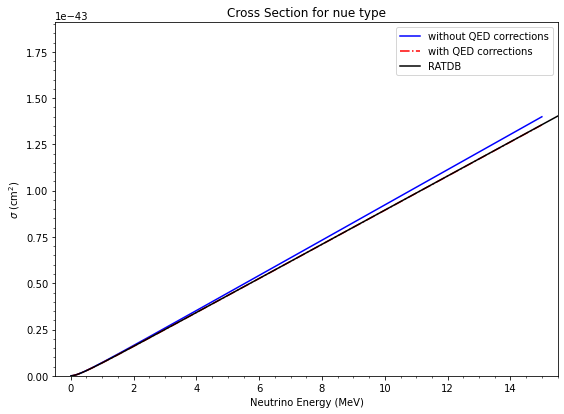

In [39]:
E_nu_min = 0.01
E_nu_max = 15
flavor = 'nue'

E_nu = np.linspace(E_nu_min, E_nu_max, 200)

cross_sec = []
cross_sec_corr = []

plt.figure(figsize = (9, 6.5))
for E_nu_i in E_nu:
    cross_sec.append(cross_sec_ES_nu_e(E_nu_i, flavor = flavor))
    cross_sec_corr.append(integrated_sigma(E_nu_i, flavor = flavor))

plt.plot(E_nu, cross_sec, color = 'b', label = 'without QED corrections')
plt.plot(E_nu, cross_sec_corr, color = 'r', linestyle = '-.', label = 'with QED corrections')
plt.plot(energy_nue, np.array(data_xsec_nue)*1e-42, color = 'black', label = 'RATDB')

plt.xlabel('Neutrino Energy (MeV)')
plt.ylabel(r'$\sigma$ (cm$^2$)')

plt.title(f'Cross Section for {flavor} type')

plt.legend(loc = 'best')

plt.xlim(E_nu_min - 0.5, E_nu_max + 0.5)
plt.ylim(0,)

ax = plt.gca() 
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator()) 

plt.show()

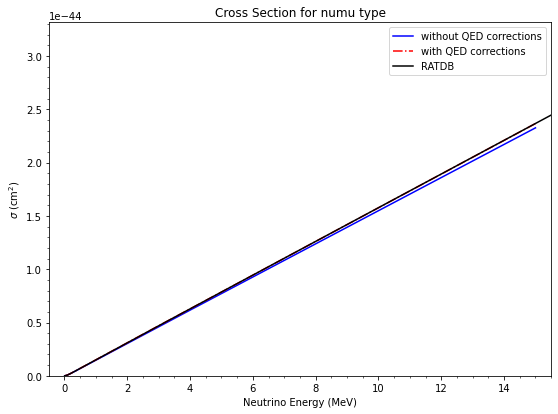

In [42]:
E_nu_min = 0.01
E_nu_max = 15
flavor = 'numu'

E_nu = np.linspace(E_nu_min, E_nu_max, 200)

cross_sec = []
cross_sec_corr = []

plt.figure(figsize = (9, 6.5))
for E_nu_i in E_nu:
    cross_sec.append(cross_sec_ES_nu_e(E_nu_i, flavor = flavor))
    cross_sec_corr.append(integrated_sigma(E_nu_i, flavor = flavor))

plt.plot(E_nu, cross_sec, color = 'b', label = 'without QED corrections')
plt.plot(E_nu, cross_sec_corr, color = 'r', linestyle = '-.', label = 'with QED corrections')
plt.plot(energy_numu, np.array(data_xsec_numu)*1e-42, color = 'black', label = 'RATDB')

plt.xlabel('Neutrino Energy (MeV)')
plt.ylabel(r'$\sigma$ (cm$^2$)')

plt.title(f'Cross Section for {flavor} type')

plt.legend(loc = 'best')

plt.xlim(E_nu_min - 0.5, E_nu_max + 0.5)
plt.ylim(0,)

ax = plt.gca() 
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator()) 

plt.show()